# KNMI Drought Analysis: SPI & SPEI

In the [previous Notebook in the series](./02-knmi_data_visualization.ipynb) we crafted a set of insightful visualizations by using the data available to us from the KNMI web script service. 

In this notebook we will go a final step deeper to analyze and even quantify periods of drought and wetness by using so-called <em>Standardized Indexes</em>. 

We will also fill missing values in the dataset using an advanced imputation algorithm called <em>MICE</em> (Multivariate or Multiple Imputation by Chained Equations), which is powered by predictive modelling to fill in missing values in our datasets.

### Disclaimer
I am not officially affiliated with KNMI, and the scripts and insights provided in this Jupyter Notebook are offered on an unofficial basis for educational and exploratory purposes.

## Background

### SPI
SPI stands for the <em>Standardized Precipitation Index</em>.

This metric is widely used to assess meteorological droughts by quantifying precipitation anomalies over a specified time scale. It compares observed precipitation to historical averages, standardizing the values to account for variability in climate and geography. 

Positive SPI values indicate wetter-than-average conditions, while negative values reflect drier-than-average conditions, with thresholds classifying the severity of drought/wetness. 

Its flexibility in evaluating short- to long-term droughts (e.g., agricultural or hydrological) makes it particularly useful for monitoring water resource availability and as an input for e.g. early-warning systems.

By being purely precipitation-based, the SPI provides a straightforward, location-independent tool for assessing drought risk across diverse regions.

### SPEI
SPEI is an abbreviation of <em>Standardized Precipitation Evapotranspiration Index</em>. It was introduced in a scientific paper by Vicente-Serrano et al. (2010) to take the effect of (rising) temperatures into account when reporting about drought. 

Instead of taking the precipiation directly as for the SPI, this index is based on the <em>excess precipitation</em> (precipitation minus reference evaporation).

Currently more meteorological organisations, including KNMI itself, are starting to use the SPEI to report about events of drought and wetness, on top of the already more commonly and broadly used SPI.

For the interested reader, also see [the Wikipedia-article on SPEI](https://en.wikipedia.org/wiki/Standardised_Precipitation_Evapotranspiration_Index).

### SP(E)I Timescales

SP(E)I indexes are commonly calculated on different timescales, with each one emphasizing the impact on different parts of the water system:
- <strong>SP(E)I-1</strong> reflects precipitation anomalies over the past month. It is a short-term indicator sensitive to immediate changes in rainfall, often associated with surface soil moisture conditions and impacts on agriculture.
- <strong>SP(E)I-3</strong> represents anomalies over a 3-month period, capturing seasonal precipitation trends. It’s commonly used to assess short-term agricultural drought and early hydrological impacts.
- <strong>SP(E)I-6</strong> bridges short- and medium-term drought effects. It provides insights into soil moisture, streamflow, and reservoir levels.
- <strong>SP(E)I-9</strong> is often tied to seasonal and medium-term water resource availability, such as impacts on larger reservoirs and river systems.
- <strong>SP(E)I-12</strong> reflects long-term hydrological conditions and water storage. Useful for understanding drought impacts on groundwater and large-scale water resources.
- <strong>SP(E)I-24</strong> captures anomalies over a 2-year period, focusing on prolonged droughts and long-term groundwater and aquifer recharge impacts.

### Why is a Data Scientist interested in these domain-specific indexes?

- Weather conditions (among which drought/wetness) are important drivers for many phenomena, even outside the direct realm of meteorology, hydrology and climate.
- Drought and wetness events are quite universally experienced, but rarely <em>quantified</em>, which makes it hard to model such events in Data Science / Machine Learning workflows.
- Standardized Indexes are location- and geography-invariant, which makes interpretation of their values universal.
- Machine Learning models tend to work very well with normalized datasets. Since the SP(E)I is a Z-score by definition (where $ Z = \frac{(X - \mu)}{\sigma} $: the number of standard deviation, $\sigma$, multiples from the mean, $\mu$), they would form a great input parameter to use for feature engineering in any Machine Learning use case where weather might play a role.

More real-life potential use cases are listed in the Reflection post-section at the end of this Notebook.

## Preparation steps
As usual, we will start by importing the required external and internal modules, scripts and libraries.

### Import external libraries
Note: these are only the external libraries used directly within this Notebook. The Python helper scripts, imported in the subsequent step, may require the installation of additional libraries.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as scs

In [2]:
import matplotlib.pyplot as plt

### Internal imports
In the code below the custom Python helper scripts powering the workflow in this Jupyter Notebook are imported.

In [3]:
import sys
sys.path.append("scripts")

In [4]:
from scripts import (
    knmi_meteo_ingest,
    knmi_meteo_transform,
    knmi_meteo_visualize,
    knmi_spi_utils,
    mice_imputation_utils
)

## List of sections: SP(E)I data analysis examples



The aim of showcasing different examples is to give you a hands-on idea on the possibilities, so that you can follow along and experiment further if desired.

The examples that we will focus on in this Jupyter Notebook are:
<ol>
<li>SPI analysis for a station with missing data</li>
<li>SPEI analysis for a station with missing data</li>
<li> SPEI long-term analysis for The Bilt</li>
</ol>

## Section 1: SPI analysis for a station with missing data

In this section we will go through a detailed step-by-step workflow to impute missing precipitation values, calculate SPI indexes over various timeframes, and analyze the results.

Since, as said before, the data quality of the KNMI datasets is very good, there are only a handful of stations with missing periods of data to start with. Because of this, it was actually not that straightforward to find a good example with missing values for performing imputation on. 

In the section we will work with the meteorological station of Soesterberg (KNMI code: $265$). 

This station is actually located quite closely to KNMI's headquarters in De Bilt. However, having been a military airfield until 2008 ([also see Wikipedia](https://en.wikipedia.org/wiki/Soesterberg_Air_Base)), an on-site meteorological observation station was also present.

### Section 1.1 - Data Preprocessing

#### Get full precipitation history of KNMI station
In the cells below we load the full precipitation history for our KNMI station of choice.

Again, feel free to change the station to another one if desired.

In [5]:
# Define code of station of interest
STN_CODE = 265

In [6]:
# Get station details for chosen code (sanity check)
stations_raw = knmi_meteo_ingest.knmi_load_meteo_stations()

# Show details of chosen station (should be non-empty)
stn = (stations_raw[stations_raw["STN"] == STN_CODE]
       .to_dict(orient="list"))

# Assert error with message of valid options for invalid stn. code
valid_stns_str = ", ".join(str(x) for x in stations_raw["STN"])
err_msg = ("Invalid station code (integer) - valid options: "
           f"{valid_stns_str}.")

assert len(stn["NAME"]) > 0, err_msg

# Show details of chosen station
pd.DataFrame(stn)

,STN,LON(east),LAT(north),ALT(m),NAME
0,265,5.274,52.13,13.9,Soesterberg


The cell below might take some time to run (15 - 30 seconds for ~100 years of data), since we are making year-by-year calls to the KNMI web script service.

In [7]:
# Get daily precipiation data from KNMI web script service
df_rainlist_y = []

year_start = 1901 # first year of data @ De Bilt
year_end = 2024

for year in range(year_start, year_end+1):
    df_rain_y = (knmi_meteo_ingest
                 .knmi_meteo_to_df(meteo_stns_list=[STN_CODE],
                                   meteo_params_list=["RH"],
                                   start_date=datetime.date(year, 1, 1),
                                   end_date=datetime.date(year, 12, 31),
                                   mode="day"))
    
    df_rainlist_y.append(df_rain_y)

In [8]:
# Concatenate each non-empty yearly series to full history;
# note: use 'ignore_index' to deduplicate indexes from yearly dfs
df_rain_raw = pd.concat([df for df in df_rainlist_y if not df.empty],
                        ignore_index=True)

In [9]:
# Show the result
df_rain_raw

,STN,YYYYMMDD,RH
0,265,19510901,NaN
1,265,19510902,NaN
2,265,19510903,NaN
3,265,19510904,NaN
4,265,19510905,NaN
...,...,...,...
20576,265,20081114,11.0
20577,265,20081115,21.0
20578,265,20081116,-1.0
20579,265,20081117,NaN


#### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset. 

As part of this transformation, all parameters are converted to whole units of measurements (in this case, $mm$) for better interpretability. Furthermore the column names are converted to a more readable format.

In [10]:
# Apply transformations to clean the raw dataset
df_rain = (knmi_meteo_transform
           .transform_param_values(df_rain_raw))

##### Additional correction 1: cut off leading and trailing empty values
As an additional step, we filter out the leading and trailing NaNs from the precipitation series. 

The reason for this extra step is that the KNMI web service returns empty values, but with valid date indexes, for every period that was not part of the original measurement history.

Let's correct for this for our use case in the cell(s) below:

In [11]:
# Cut off leading and trailing NaNs from history dataset;
# in this way we get our actual historical start and end dates
min_idx = df_rain[["rain_sum"]].apply(pd.Series.first_valid_index).max()
max_idx = df_rain[["rain_sum"]].apply(pd.Series.last_valid_index).min()
df_rain = df_rain.loc[min_idx: max_idx, :]

In [12]:
# Show the result
df_rain

,station_code,date,rain_sum
8309,265,1974-06-01,0.300
8310,265,1974-06-02,0.300
8311,265,1974-06-03,7.400
8312,265,1974-06-04,0.000
8313,265,1974-06-05,0.000
...,...,...,...
20574,265,2008-11-12,0.200
20575,265,2008-11-13,0.000
20576,265,2008-11-14,1.100
20577,265,2008-11-15,2.100


##### Additional correction 2: ensure complete month indexes
So far we have successfully cut off leading and trailing empty values (NaNs).

However, for our monthly SPI aggregations (which we will calculate later on), it is easiest to work with completely-full months from start to end.

In the cells below, the first and last month of the dataset are ensured to be filled with NaNs so that any month in the dataset has an index for the entire period within that month.

Let's go ahead and do this in the cell(s) below:

In [13]:
# Now, re-index DataFrame so that it:
# 1. Always starts at first day of the first month found
first_date = df_rain["date"].iloc[0]
last_date = df_rain["date"].iloc[-1]
target_first_date = datetime.date(year=first_date.year, 
                                  month=first_date.month, 
                                  day=1)

# 2. Always ends on last day of last month found
target_last_date = (datetime.date(year=(last_date.year + (last_date.month // 12)),
                                  month=(last_date.month % 12) + 1,
                                  day=1) 
                                  - datetime.timedelta(days=1))

# 3. Always has NaNs for missing indexes in the range
full_month_index = pd.date_range(target_first_date, target_last_date, freq="D")

# Set range of collected non-NaN dates as initial index
df_rain.index = pd.to_datetime(df_rain["date"])

# Reindex to full months
df_rain = df_rain.reindex(full_month_index)

In [14]:
# Show the result
df_rain

,station_code,date,rain_sum
1974-06-01,265.0,1974-06-01,0.3
1974-06-02,265.0,1974-06-02,0.3
1974-06-03,265.0,1974-06-03,7.4
1974-06-04,265.0,1974-06-04,0.0
1974-06-05,265.0,1974-06-05,0.0
...,...,...,...
2008-11-26,NaN,NaN,NaN
2008-11-27,NaN,NaN,NaN
2008-11-28,NaN,NaN,NaN
2008-11-29,NaN,NaN,NaN


Great! Now let's rework the overview to only include the columns that we are interested in:

In [15]:
# Remove station code and "incomplete" date column
drop_cols = ["date", "station_code"]
df_rain = df_rain.loc[:,~df_rain.columns.isin(drop_cols)]

# Rename full-month index to "date"
df_rain = df_rain.rename_axis(index="date")
df_rain

,rain_sum
date,
1974-06-01,0.3
1974-06-02,0.3
1974-06-03,7.4
1974-06-04,0.0
1974-06-05,0.0
...,...
2008-11-26,NaN
2008-11-27,NaN
2008-11-28,NaN


#### Quick precipitation plot
Let's create a quick visualization of the precipitation timeseries for this station:

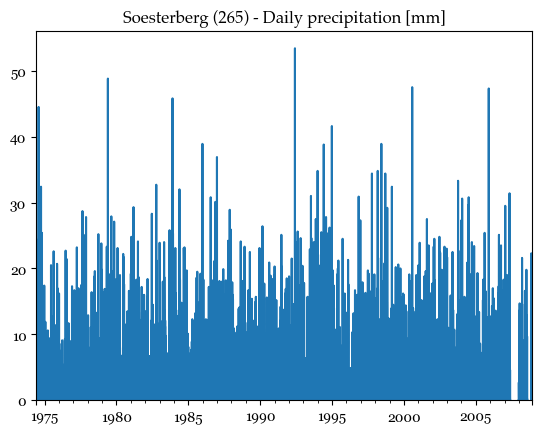

In [16]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Daily precipitation [mm]")

# Ensure only the precipitation column is plotted
ax = df_rain[["rain_sum"]].plot()

# Customize title and layout
ax.set_title(plot_title, **textfont)

# Customize x-label and legend (make invisible)
ax.set_xlabel(None)
ax.get_legend().remove()

# Customize font of the tick markers
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)

# Enforce correct y-axis limits for precipitation
ax.set_ylim(0, 1.05 * df_rain.max().max())

plt.show()

#### Observations
The precipitation dataset for our KNMI station of choice (Soesterberg) covers a period between 1974 and 2008, where only a few timespans post-2005 seem to be absent.

Let's follow up by pinpointing exactly which months contain missing values.

#### Obtain monthly summary of missing values

##### Ensure that dates are in a column
For the (month-based) grouping to function correctly, we need to ensure that the dates are part of one of the columns instead of an index:

In [17]:
# Convert full date into column for Grouper
if df_rain.index.name == "date":
    df_rain = df_rain.reset_index()

df_rain

,date,rain_sum
0,1974-06-01,0.3
1,1974-06-02,0.3
2,1974-06-03,7.4
3,1974-06-04,0.0
4,1974-06-05,0.0
...,...,...
12597,2008-11-26,NaN
12598,2008-11-27,NaN
12599,2008-11-28,NaN
12600,2008-11-29,NaN


##### Apply grouping with a custom aggregation
In order to calculate totals based on any kind of group, we make use of the convenience <code>pd.Grouper</code> object from Pandas.

Standard aggregation functions to run on grouped data are e.g. the <em>mean</em>, <em>count</em> or <em>sum</em>. 

However, in the cell below, we will define and apply our own custom lambda function. In this way we can directly calculate the <em>percentage of missing values</em> (NaNs) in each group, with each group representing a month in the dataset.

In [18]:
# Create custom aggregator for counting NaN percentage per group
agg_func = lambda x: 100.0 * np.mean(np.isnan(x))
agg_obj = pd.NamedAgg(column="rain_sum",
                      aggfunc=agg_func)

# Define grouper to group dates by month; keep month starts as label
grouper_obj = pd.Grouper(key="date", freq="MS")

# Perform grouping to the df to get monthly NaN percentages
df_rain_grouped = (df_rain.groupby(grouper_obj)
                   .agg(month_nan_perc=agg_obj))

In [19]:
# Show the result
df_rain_grouped

,month_nan_perc
date,
1974-06-01,0.000000
1974-07-01,0.000000
1974-08-01,0.000000
1974-09-01,0.000000
1974-10-01,0.000000
...,...
2008-07-01,9.677419
2008-08-01,100.000000
2008-09-01,100.000000


##### Convert overview to pivoted table
Let's continue and convert our "long"-format DataFrame to a "wide"-format to get a clearer visual result of the outcome.

In [20]:
# Now, pivot on 'month' as cols, 'year' as index
df_rain_grouped["month"] = df_rain_grouped.index.month
df_rain_grouped["year"] = df_rain_grouped.index.year

df_rain_monthpivot = (df_rain_grouped
                      .pivot_table(index="year", columns="month",
                                   values="month_nan_perc"))

In [21]:
# Show the (rounded) result
df_rain_monthpivot.round(1)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1974,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Find months with missing values from dataset
df_rain_grouped[df_rain_grouped["month_nan_perc"] > 0]

,month_nan_perc,month,year
date,,,
2005-07-01,3.225806,7,2005
2007-05-01,29.032258,5,2007
2007-06-01,100.000000,6,2007
2007-07-01,100.000000,7,2007
2007-08-01,100.000000,8,2007
2007-09-01,100.000000,9,2007
2007-10-01,100.000000,10,2007
2007-11-01,100.000000,11,2007
2007-12-01,83.870968,12,2007


Great! At this point we have clearly identified the timelines of our missing data points.

### Section 1.2 - Imputing missing data

There are many ways to handle missing data. What frequently happens in data analysis and Machine Learning workflows, is that missing data is dropped or ignored outright. Although this speeds up experimentation and certainly simplifies workflows, it rarely yields the best results.

Another popular approach is filling missing values with summary statistics (<em>single imputation methods</em>), e.g.: the <em>mean</em>, <em>median</em> or <em>most-frequent</em> value. This is usually more accurate than dropping data, but still oversimplifies or discards useful patterns that might exist in the empty data rows.


#### MICE
In this analysis we are going a step beyond and apply a more advanced approach called <strong>MICE</strong>: <em>Multiplicative</em> or <em>Multiple Imputation by Chained Equations</em>. 

This approach works on an iterative basis. For each variable with missing data, a predictive model is built using the other variables, and missing values are imputed based on this model. This process is repeated for all variables in a "chained" manner until convergence is reached. 

By creating multiple imputed datasets, MICE accounts for the uncertainty of missing values. This allows for robust statistical analyses and insights without introducing bias as from <em>single imputation methods</em>.

Unfortunately, unlike R, for which a [directly available MICE package](https://amices.org/mice/) exists, Python does not (yet) have a similar built-in library for applying a MICE algorithm directly.

Thankfully, [the brief but great tutorial from NumpyNinja in this link](https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values) provides a clear explanation on using <code>sklearn</code>'s experimental <code>IterativeImputer</code> object to reach the same objective. 

#### Custom implementation for our analysis
The default MICE algorithm use case aims to fill empty values from <u>all</u> feature columns in a dataset. 

However, in our analysis here we are primarily interested in filling empty values for <u>one</u> specific column: the precipitation data of our KNMI station of interest.

In helper script <code>mice_imputation_utils.py</code>, a randomly sampled 25 % of the data from our column of interest will be used for evaluating various prediction models, namely:
- Linear Regression
- Ridge
- Lasso
- Bayesian Ridge
- Random Forest Regressor (Machine Learning-based)
- Gradient Boosting Regressor (Machine Learning-based)
- K-Nearest Neighbors Regressor (Machine Learning-based)

The model that provides the most accurate imputation values is then chosen as our best imputer, and subsequently applied to the full dataset to impute the missing values from that column.

In short: not only will we apply a MICE algorithm, but we will also choose the <em>best-working</em> imputer from a wide range of prediction models to fill our missing values. Pretty exciting stuff!

Let's continue further to see this approach in action.

#### Which features to use?

As we have seen in the other Jupyter Notebooks, KNMI possesses many automatic stations in which precipitation is measured. Therefore we will use the observed precipitation values from these <em>other stations</em> to use as features for our imputation dataset. 

As long as the other stations do not all have broadly overlapping periods of missing (precipitation) observations, the relational data patterns between the stations can be captured to fill the missing values from our station of interest.

#### How many other features to use?
According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) of <code>sklearn.IterativeImputer</code>, the MICE-algorithm order of complexity (O-complexity) scales as follows with the number of features (and therefore the amount of time needed to run it in a worst-case situation):
$$
O(k \cdot n \cdot p^{3} \cdot min(n,p))
$$
In the formula above, $k$ is the number of iterations (default value $20$ in the MICE helper script), $n$ the number of records (days of data to fill), and $p$ the number of features (columns) in the dataset. Assuming we have more days of data to fill than the number of stations available to us (therefore $min(n, p) = p$), the worst-case runtime will have an O-complexity of: 
$$
O(k⋅n⋅p^{4})
$$
This means that for every doubling of features (columns), the runtime may increase up to sixteenfold. Therefore, limiting the number of features (columns) in our dataset is of utmost importance to keep performance. Even more so since we are going to test many model variants by use of this method.

Conclusively: we will only select the $5$ best-correlating other stations as features for our imputation dataset. That should strike a good balance between having sufficient other columns in the dataset for the imputation algorithm to "learn" from for all rows in the dataset, while simultaneously preventing overfitting and keeping the algorithm runtime acceptable.

#### Find full years to run imputation for
For starters, there are many possible ways in which we can choose the periods for our imputation dataset.

In order to strike a balance between accuracy (the more data, the better) and computation time (the less data, the faster), we will fetch and use the other-station data for all <strong>full years</strong> in which any row (day) of missing data was found.

Words of caution:
- Please note that, in case you use another measurement station for your analysis, the method outlined below might not work (well) if all years in your dataset have almost 100 % of missing data. The MICE algorithm needs a certain degree of overlap between non-empty values to "learn" from.
- On the other hand, if only a few days of data are missing from your dataset, a simpler imputation method or outright dropping of the data will only minimally impact the final calculations. In those situations, the method followed below will be somewhat over-engineered for your use case.

In [23]:
# Find unique years to run imputation for
years_to_impute = list(set((df_rain_grouped
                   [df_rain_grouped["month_nan_perc"] > 0]
                   ["year"]).tolist()))

years_to_impute.sort()

print(years_to_impute)

[2005, 2007, 2008]


#### Fetch data of other KNMI stations

In the cells below we fetch the daily precipitation values of all other KNMI meteo stations for the full years to impute for:

In [24]:
try_impute = False
df_implist_y = []

if len(years_to_impute) > 0:
    # Get rain data of all stations for years to impute for
    try_impute = True

    for year in years_to_impute:
        df_imp_y = (knmi_meteo_ingest
                    .knmi_meteo_to_df(
                        meteo_stns_list=None,
                        meteo_params_list=["RH"],
                        start_date=datetime.date(year, 1, 1),
                        end_date=datetime.date(year, 12, 31),
                        mode="day")
                    )
    
        df_implist_y.append(df_imp_y)

In [25]:
# Concatenate each non-empty yearly series to full history;
# note: use 'ignore_index' to deduplicate indexes from yearly dfs
if try_impute:
    if len(df_implist_y) > 0:
        df_imp_raw = pd.concat(
            [df for df in df_implist_y if not df.empty],
            ignore_index=True)

#### Clean (transform) imputation dataset

As usual, we clean the "raw" KNMI meteo dataset as in the cell below.

In [26]:
if not try_impute:
    df_imp = pd.DataFrame()

if try_impute:
    # Apply transformations to clean the raw dataset
    df_imp = (knmi_meteo_transform
              .transform_param_values(df_imp_raw))

# Show the result
df_imp

,station_code,date,rain_sum
0,209,2005-01-01,NaN
1,209,2005-01-02,NaN
2,209,2005-01-03,NaN
3,209,2005-01-04,NaN
4,209,2005-01-05,NaN
...,...,...,...
52973,391,2008-12-27,0.0
52974,391,2008-12-28,0.0
52975,391,2008-12-29,0.0
52976,391,2008-12-30,0.0


#### Pivot the imputation dataset

Instead of having a "long"-format DataFrame, let's pivot the overview towards one where the dates are indexes and the KNMI station code are columns.

In [27]:
if not try_impute:
    df_imp_pivot = pd.DataFrame()

if try_impute:
    # Pivot data with 'date' as index, 'stn_code' as cols
    df_imp_pivot = (df_imp.pivot(index="date",
                                 columns="station_code"))

    # Flatten pivot table to single index
    df_imp_pivot.columns = (df_imp_pivot.columns
                            .get_level_values(1))
    
# Show the result
df_imp_pivot

station_code,209,210,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,1.5,NaN,0.600,2.100,NaN,NaN,1.4,4.0,0.7,...,NaN,1.2,2.100,1.4,3.1,1.000,1.9,0.900,1.000,1.100
2005-01-02,NaN,0.1,NaN,0.025,0.000,NaN,NaN,0.0,0.4,0.0,...,NaN,0.0,0.025,0.7,0.0,0.500,0.0,0.200,0.000,0.700
2005-01-03,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,1.6,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.2,0.025,0.025,0.025
2005-01-04,NaN,0.9,NaN,3.300,1.500,NaN,NaN,1.5,0.4,1.1,...,NaN,3.1,1.200,0.4,1.2,0.025,0.3,0.025,0.400,0.100
2005-01-05,NaN,2.4,NaN,4.400,3.300,NaN,NaN,4.4,3.3,3.9,...,NaN,1.2,1.500,1.6,1.8,0.800,1.5,1.000,2.100,0.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-27,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
2008-12-28,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
2008-12-29,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000


#### Sort stations based on correlation with our chosen station

Now we calculate the correlation of all other stations with regard to our station of interest, and sort the results by value. 

Note that we sort the correlation by absolute value. Reason for this is that a strong negative correlation is just as useful to "learn" from as a strong positive correlation.

For our use case of Dutch precipitation only, however, negative correlations are not at all to be expected. Reason for this is that in general a lot of broad "rain fronts" pass over; usually rain in one place means another nearby place will be likely rainy as well. Similarly, dry days in one place generally also translate to dry days nearby (definitely more often than not). In negative-correlation territory, the opposite situation would be the case, namely: rain in one place translates to drought or less rain in another. This is something we rarely see around The Netherlands.

However, if we would intertwine e.g. precipitation and evaporation (which we will not do in this Notebook), the story would most likely change, as high evaporation tends to be associated with warm, dry days. At the same time, low evaporation is associated with cold sunless days.

Let's sort the other stations by (absolute) correlation with the precipitation from our station of interest in the cell below:

In [28]:
# Sort all stations on correlation with target station;
# the station itself will have a value of 1 (by definition)
corr_scores = []
if try_impute:
    corr_scores = (((df_imp_pivot
                     .corrwith(df_imp_pivot[STN_CODE]
                             ) ** 2) ** 0.5)
                   .sort_values(ascending=False))

pd.DataFrame({"abs_corr": corr_scores})

,abs_corr
station_code,
265,1.000000
260,0.933660
356,0.845402
275,0.841238
240,0.792410
210,0.790389
257,0.775355
375,0.775257
269,0.772231


#### Only keep best-correlating other stations
As mentioned before, since $t_{MICE} \propto p^{4}$, the MICE algorithm runtime scales to the fourth power for every extra feature (column) added. 

Because of this, let's choose to only use the $5$ best-correlating other meteo stations as imputation feature columns. 

In [29]:
run_impute = False

if try_impute:
    # Find up to N best-correlating stations for imputation years
    # Note: less stations will be used in case of empty results
    nr_impute_stns = 5

    # Drop NaNs from the correlation scores
    corr_scores = corr_scores[~corr_scores.isna()]

    # Get maximum index (minimum of N and non-NaN corr elements)
    max_corr_idx = min(1 + nr_impute_stns, len(corr_scores))
    impute_stn_codes = corr_scores[1 : max_corr_idx].index.tolist()

    # Print warning message in case of all-NaN correlations
    warn_msg = ("No matching stations found for MICE imputation; use "
               "another method or drop missing data instead of imputing.")
    if len(impute_stn_codes) == 0:
        print(warn_msg)
    else:
        # Only run impute if max. found correlation is at least 0.5
        if max(np.abs(corr_scores[1 : max_corr_idx])) >= 0.5:
            # If all OK, set `run_impute` to True
            run_impute = True
        else:
            warn_msg = (f"None of the stations show >= |{0.5}| corr.;"
                        " use another method or drop missing data instead.")
            print(warn_msg)

    # If all OK, print external station codes to use for imputation
    print(impute_stn_codes)

[260, 356, 275, 240, 210]


Fantastic! Now that we have identified which stations to use for our imputation dataset, we can filter out the others. 

In that way we will be left with only the most important feature columns.

In [30]:
# Placeholder for pretty printing in all scenarios
df_imp_sel = pd.DataFrame()

if run_impute:
    # Define colums to keep for imputation calculation
    keep_cols = [STN_CODE] + impute_stn_codes

    # Apply column filter
    df_imp_sel = df_imp_pivot.loc[:, df_imp_pivot.columns.isin(keep_cols)]

    # Ensure that our target impute column is always the first
    df_imp_sel = df_imp_sel[[STN_CODE] + impute_stn_codes]

    # Get maximum value from imp. dataset; no imp. value should be larger
    max_imp_val = np.nanmax(df_imp_sel.values)

# Show the result (table with data to use for imputation, if any)
df_imp_sel

station_code,265,260,356,275,240,210
date,,,,,,
2005-01-01,1.600,1.300,3.1,2.6,2.100,1.5
2005-01-02,0.025,0.025,0.0,0.1,0.000,0.1
2005-01-03,0.000,0.000,0.0,0.0,0.000,0.0
2005-01-04,1.100,1.600,1.2,1.4,1.500,0.9
2005-01-05,3.400,3.200,1.8,2.8,3.300,2.4
...,...,...,...,...,...,...
2008-12-27,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-28,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-29,NaN,0.000,0.0,0.0,0.000,0.0


#### Test and fit best MICE imputation model to dataset

By now our imputation dataset is all set up and ready for the heavy-lifting exercise: testing and fitting the vast range of different predictor models, enabling us to find the best-performing imputer on our precipitation dataset.

In helper script <code>mice_imputation_utils.py</code>, a function was written to conveniently do all this for us automatically.

The best-performing model is defined based on a mix of $R^2$ and $RMSE$, using the following scoring formula:

$score = \alpha \cdot RMSE - (1 - \alpha) \cdot (1 - R^2)$

The script below uses $\alpha = 0.50$ by default. It can be set dynamically by changing input parameter <code>rmse_r2_alpha</code>.

Depending on the ease of convergion of the found solutions, particularly for the Machine Learning-based predictors, the code below will run for 30 seconds to several minutes. 

Note that the removal of the Machine Learning-based predictors from the list of models to try and fit (in script <code>mice_imputation_utils.py</code>) would cause the script below to run tremendously faster.

In [31]:
if not run_impute:
    df_imp_filled = pd.DataFrame()

if run_impute:
    (best_imputer, best_res, df_imp_filled) = (
        mice_imputation_utils
        .fit_best_df_imputer_on_targetcol(df_imp_sel, STN_CODE)
    )

df_imp_filled

Testing 'LinearRegression' model(s):
  Params: {}, MSE: 2.4015, R^2: 0.8838, score: 0.7168
Testing 'Ridge' model(s):
  Params: {'alpha': 0.1}, MSE: 2.4015, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 1.0}, MSE: 2.4013, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 10.0}, MSE: 2.3991, R^2: 0.8839, score: 0.7164
Testing 'Lasso' model(s):
  Params: {'alpha': 0.001}, MSE: 2.4013, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 0.01}, MSE: 2.3984, R^2: 0.8840, score: 0.7163
  Params: {'alpha': 0.1}, MSE: 2.3792, R^2: 0.8849, score: 0.7137
  Params: {'alpha': 1.0}, MSE: 2.4937, R^2: 0.8794, score: 0.7292
  Params: {'alpha': 10.0}, MSE: 7.4999, R^2: 0.6372, score: 1.1879
Testing 'Random Forest' model(s):
  Params: {'max_depth': 3, 'n_estimators': 10}, MSE: 2.1170, R^2: 0.8976, score: 0.6763
  Params: {'max_depth': 3, 'n_estimators': 20}, MSE: 2.1550, R^2: 0.8957, score: 0.6819
  Params: {'max_depth': 3, 'n_estimators': 50}, MSE: 2.3326, R^2: 0.8871, score: 0.7072
  Params: {'max_depth': 3,

station_code,265,260,356,275,240,210
date,,,,,,
2005-01-01,1.600000,1.300,3.100,2.600,2.100,1.5
2005-01-02,0.025000,0.025,0.000,0.100,0.000,0.1
2005-01-03,0.000000,0.000,0.000,0.000,0.000,0.0
2005-01-04,1.100000,1.600,1.200,1.400,1.500,0.9
2005-01-05,2.817817,3.200,1.800,2.800,3.300,2.4
...,...,...,...,...,...,...
2008-11-12,1.276591,0.700,1.200,1.500,2.500,5.1
2008-11-13,0.203411,0.100,0.025,0.100,0.025,1.4
2008-11-14,1.263952,0.800,0.900,1.300,0.900,0.4


In [32]:
# Print (hyperparameter) properties of best-fit model
if run_impute:
    print(best_imputer.estimator)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)


Quite impressive! For KNMI station Soesterberg, the best-performing model is a Random Forest regressor with a maximum depth of 5 tree layers and 50 estimators. 

More complex models were tested (deeper and more estimators), but apparently this mid-complexity hyperparameter setup strikes the best balance between reflecting the patterns within the data, while simultaneously not overfitting only on the data seen.

The $R^2$ of the tested imputation values (compared to the real ones within that 25 % withheld subset) is almost 91 %, with a $RMSE$ of 1.36 $mm$. 

Also note from the output of the cells above that the baseline linear regression model would already have yielded quite decent results ($RMSE$ of 1.55 $mm$, $R^2 \approx 88.4 \% $), while simultaneously saving us substantial computing time. So if speed and simplicity were the main objectives rather than pure accuracy, that would be a very sensible choice. 

For illustrative and educational purposes, however, we will continue below using the best-performing model.

#### Fill missing dataset values using the best-fit imputer
Let's unleash our best-performing imputer on the full to-impute dataset, so that we can definitively say goodbye to any missing values for our example of interest.

In [33]:
if not run_impute:
    df_imputed = pd.DataFrame()
if run_impute:
    # Now fit and run the best imputer on the *full* to-impute dataset
    df_imputed = pd.DataFrame(data=best_imputer.fit_transform(df_imp_sel),
                              columns=df_imp_sel.columns,
                              index=df_imp_sel.index)

    # Only keep imputed values that were missing in dataset
    df_imputed["init_val"] = df_imp_sel[STN_CODE]
    df_imputed = df_imputed[df_imputed["init_val"].isna()]
    df_imputed = df_imputed.loc[:, [STN_CODE]]

    # Convert index type to DateTime
    df_imputed.index = pd.to_datetime(df_imputed.index)

    # Rename columns and reset 'date' col; show the result
    df_imputed = (df_imputed
                  .rename(columns={STN_CODE: "rain_sum_imputed"})
                  .reset_index())

df_imputed

station_code,date,rain_sum_imputed
0,2005-07-31,16.091713
1,2007-05-23,0.008186
2,2007-05-24,0.008186
3,2007-05-25,0.008186
4,2007-05-26,1.582548
...,...,...
358,2008-12-27,0.008186
359,2008-12-28,0.008186
360,2008-12-29,0.008186
361,2008-12-30,0.008186


#### Merge original dataset with imputed dataset
Now it is time to merge the imputed dataset with the original dataset. 

We will keep the dataset columns separate for now. This will enable us to mark imputed data separately later on.

Also note that we drop some of the imputed values during merging, since the imputed values for Dec 2008 fall outside of the station's measurement history in our example of interest. 

If keeping those days is desired, change the merge rule in the cell below from "left" to "outer".

In [34]:
if run_impute:
    # Merge imputed data with measured data if imputation was run
    df_rain_all = df_rain.merge(df_imputed, how="left", on="date").round(2)
else:
    # If no missing data were found, only add all-NaN imputation column
    df_rain_all = df_rain.copy()
    df_rain_all["rain_sum_imputed"] = np.nan

df_rain_all

,date,rain_sum,rain_sum_imputed
0,1974-06-01,0.3,NaN
1,1974-06-02,0.3,NaN
2,1974-06-03,7.4,NaN
3,1974-06-04,0.0,NaN
4,1974-06-05,0.0,NaN
...,...,...,...
12597,2008-11-26,NaN,0.69
12598,2008-11-27,NaN,0.10
12599,2008-11-28,NaN,0.01
12600,2008-11-29,NaN,0.28


In [35]:
print("Values in original dataset: "
      f"{df_rain_all["rain_sum"].notna().sum()}"
      "\nValues in imputed dataset: "
      f"{df_rain_all["rain_sum_imputed"].notna().sum()}")

Values in original dataset: 12270
Values in imputed dataset: 332


#### Quick plot of measured and imputed precipitation
Let's create a new precipitation plot for this station, now with imputed values included as well:

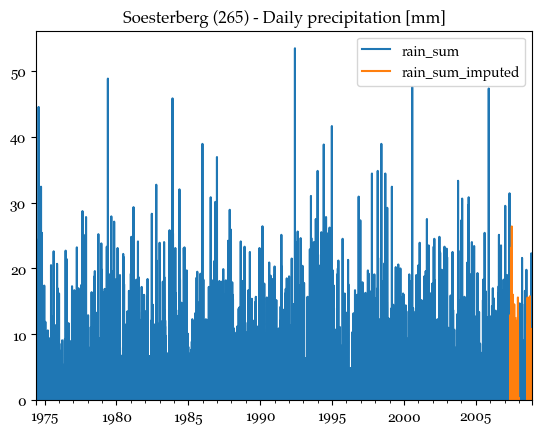

In [36]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Daily precipitation [mm]")

# Ensure only the precipitation columns are plotted
ax = (df_rain_all.set_index("date")
      [["rain_sum", "rain_sum_imputed"]]).plot()

# Customize title and layout
ax.set_title(plot_title, **textfont)

# Customize x-label (make invisible) and legend text
ax.set_xlabel(None)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)

# Enforce correct y-axis limits for precipitation
y_max = 1.05 * np.nanmax(df_rain_all.set_index("date").values)
ax.set_ylim(0, y_max)

plt.show()

##### Observations
When looking at the imputed precipitation data at a first glance, it seems like they could have been part of the original precipitation dataset.

Mainly the peaks seem to absent in the imputed dataset. The reason for this could be twofold: either no heavy-rain days were present in the period of the imputed dataset, or heavy rain during that timeframe was too localized to be picked up from the measurements of the other stations.

#### Comparing distributions of measured and imputed precipitation

Let's dive a bit deeper into the actual data distributions of the measured data and the imputed data.

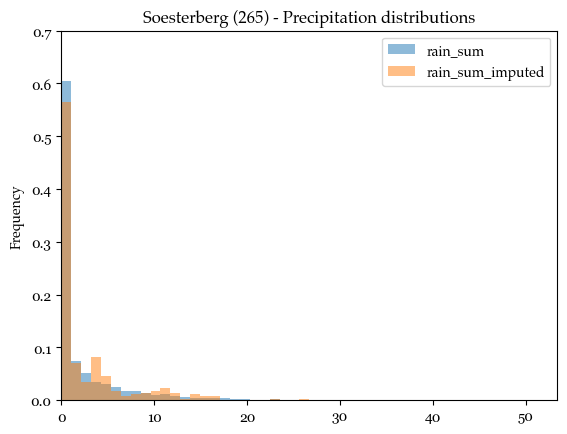

In [37]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Precipitation distributions")

# Ensure only the precipitation columns are plotted
ax = (df_rain_all.set_index("date")
      [["rain_sum", "rain_sum_imputed"]]).plot(
          kind="hist", bins=50, density=True,
          alpha=0.5
      )

# Customize title and layout
ax.set_title(plot_title, **textfont)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_ylabel(ax.get_ylabel(), **textfont)

# Enforce correct x-axis histogram limits 
x_max = np.nanmax(df_rain_all.set_index("date").values)
ax.set_xlim(0, x_max)

plt.show()

##### Observations
Generally speaking the distributions of the imputed (orange) and measured (blue) datasets seem to align quite well. 

The imputed data shows a slightly higher tendency to estimate the rainfall being 3 - 4 mm or between 10 - 20 mm compared to the measured data, where there seems to be a slight under-bias for estimating (near)-zero-precipitation days.

However, we must keep in mind that for our example of interest the number of imputed day values are only around 332, where the measured dataset contains 12270 records. 

Because of this, the imputed data will show more short-term seasonal effects than the all-history measured precipitation values.

##### Log-distribution comparison
The higher precipitation values barely show up in the originally-scaled distribution plot, since they occur relatively rarely.

By using a logarithmic scale for the y-axis, we can show the comparison between the data distributions for those values more clearly below.

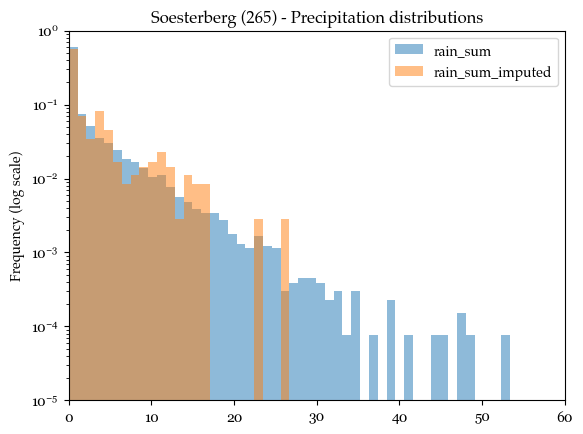

In [38]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Precipitation distributions")

# Ensure only the precipitation columns are plotted
ax = (df_rain_all.set_index("date")
      [["rain_sum", "rain_sum_imputed"]]).plot(
          kind="hist", bins=50, density=True,
          logy=True, alpha=0.5
      )

# Customize title and layout
ax.set_title(plot_title, **textfont)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_ylabel(f"{ax.get_ylabel()} (log scale)", **textfont)

# Enforce correct x- and y-axis histogram limits 
ax.set_xlim(0)
ax.set_ylim(1e-5, 1e0)

plt.show()

##### Observations
It becomes clear that the imputed values do not exceed the 25 $mm$-mark, where the full measured dataset has several occcurrences that have much higher peaks, up to over 50 $mm$.

However, what must be noted is that any frequency below $1 / 332  \approx 3 \cdot 10^{-2}$ is not possible for the imputed dataset, and therefore cannot be modeled well.

With that in mind, it seems like the high-peak precipitation days occur too rarely to be accurately captured within the limited timeframe of the imputation dataset.

Let's confirm below whether we actually had any high peak-intensity rainfall during the timeframe of imputation to start with.

In [39]:
# Start and end date filters
start_date = df_rain_all["date"].min().date()
end_date = df_rain_all["date"].max().date()

# Filter for only showing rows for timeframe of imputed data
is_imput_row = (df_imp_pivot.index.isin
                ([d.date() for d in df_imputed["date"]]))

# Filter for start and end date
is_in_date_range = ((df_imp_pivot.index >= start_date)
                    & (df_imp_pivot.index <= end_date))

In [40]:
# Apply all filters to original imputation dataset;
# check upper-bound extreme values
((df_imp_pivot
  [impute_stn_codes]
  [is_imput_row & is_in_date_range]
  ).describe(percentiles=[0.5, 0.99, 0.995, 0.9975, 0.999]))

station_code,260,356,275,240,210
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,2.874398,2.728991,2.502711,2.802861,2.807455
std,5.141176,5.336327,4.531154,5.729920,5.371223
min,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,0.200000,0.350000,0.350000,0.300000
99%,23.187000,20.466000,22.105000,26.114000,20.876000
99.5%,27.072500,28.687500,26.686500,41.528000,36.952500
99.75%,29.142250,36.429000,27.817250,43.962500,40.003500
99.9%,34.156900,44.571600,27.866900,46.445000,40.301400
max,37.500000,50.000000,27.900000,48.100000,40.500000


Based on the near-100th percentiles of each (precipitation) feature column, we can derive for our example of interest that:
- $1/200$ values ($99.5^{th}$ percentile) exceed $26.7 - 41.5 \ mm$
- $1/400$ values ($99.75^{th}$ percentile) exceed $27.8 - 44.0 \ mm$
- $1/1000$ values ($99.9^{th}$ percentile) exceed $27.9 - 46.4 \ mm$

Based on the fact that we have only $332$ values in our imputed dataset, and that rain peaks likely do not all occur at the same time for all stations (since sharp peaks in rainfall tend to be local phenomena), a maximum prediction of $\sim26 \ mm$ for the imputed dataset seems reasonable.

Therefore we can conclude that the imputed values are not showing up in the high-rainfall regions simply because they were too infrequent to capture within the timeframe of missing values.

#### Merge observed and imputed results
Let's continue by merging the observed precipitation values with the imputed data.

In the cells below we will keep track for each row whether the value in it was measured or imputed.

In [41]:
# Keep track of fact whether data was imputed or not
df_rain_all["is_imputed"] = (df_rain_all["rain_sum"].isna() 
                             & ~df_rain_all["rain_sum_imputed"].isna())

# Create a fully-filled column with mixed real and imp. values
# Start by filling the column with the originally measured data
df_rain_all["rain_sum_all"] = df_rain_all["rain_sum"].copy()

# Fill the "_all" column with imputed data wherever applicable
filter_idxs = df_rain_all[df_rain_all["rain_sum_all"].isna()].index
df_rain_all.loc[filter_idxs, "rain_sum_all"] = df_rain_all["rain_sum_imputed"].copy()

df_rain_all

,date,rain_sum,rain_sum_imputed,is_imputed,rain_sum_all
0,1974-06-01,0.3,NaN,False,0.30
1,1974-06-02,0.3,NaN,False,0.30
2,1974-06-03,7.4,NaN,False,7.40
3,1974-06-04,0.0,NaN,False,0.00
4,1974-06-05,0.0,NaN,False,0.00
...,...,...,...,...,...
12597,2008-11-26,NaN,0.69,True,0.69
12598,2008-11-27,NaN,0.10,True,0.10
12599,2008-11-28,NaN,0.01,True,0.01
12600,2008-11-29,NaN,0.28,True,0.28


In [42]:
# Only keep parameter column and imputation label (yes/no)
keep_cols = ["date", "rain_sum_all", "is_imputed"]
df_rain_sel = df_rain_all[keep_cols]

df_rain_sel

,date,rain_sum_all,is_imputed
0,1974-06-01,0.30,False
1,1974-06-02,0.30,False
2,1974-06-03,7.40,False
3,1974-06-04,0.00,False
4,1974-06-05,0.00,False
...,...,...,...
12597,2008-11-26,0.69,True
12598,2008-11-27,0.10,True
12599,2008-11-28,0.01,True
12600,2008-11-29,0.28,True


Awesome! 

We now have a complete, non-NaN dataset for our example of interest, and a separate marker for whether the data was imputed (<code>is_imputed</code> = $True$) or measured (<code>is_imputed</code> = $False$).

#### Aggregate precipitation to 1 month
Using the convenience object <code>pd.Grouper</code> from Pandas, we convert the daily precipitation dataset to monthly totals. We use <em>mean</em> to summarize the proportion of imputed data for each month. We use a custom summing function to ensure that any still-missing day makes the entire summed month <code>NaN</code> as well. 

In this way we can be sure that no incomplete months are used for fitting a distribution (and thereby skewing the results) later on.

In [43]:
# Set aggregation rules; any aggregate that still has any NaN(s) 
# in its value is summed to NaN as a whole (prevent later fit errors)
lambda_sum = lambda x: np.nan if x.isnull().any() else x.sum()
agg_dict = {"rain_sum_all": lambda_sum,
            "is_imputed": "mean"}

In [44]:
# Aggregate dataset to months
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_m_gr = (df_rain_sel
                .groupby(grouper_obj)
                .agg(agg_dict))

df_rain_m_gr

,rain_sum_all,is_imputed
date,,
1974-06-01,55.80,0.000000
1974-07-01,84.02,0.000000
1974-08-01,94.68,0.000000
1974-09-01,124.34,0.000000
1974-10-01,142.84,0.000000
...,...,...
2008-07-01,105.79,0.096774
2008-08-01,99.16,1.000000
2008-09-01,63.53,1.000000


#### Aggregate precipitation to $N$ months
Now that the one-month totals are calculated, let's use a rolling window function from Pandas to generalize these totals to any $N$ number of months. 

We use the same aggregation rules as before, and test its functionality using $N = 3$ months (change this value if desired):

In [45]:
# Use rolling window to aggregate N months
N = 3
df_rain_sums = df_rain_m_gr.rolling(window=N).agg(agg_dict)

df_rain_sums

,rain_sum_all,is_imputed
date,,
1974-06-01,NaN,NaN
1974-07-01,NaN,NaN
1974-08-01,234.50,0.000000
1974-09-01,303.04,0.000000
1974-10-01,361.86,0.000000
...,...,...
2008-07-01,193.71,0.032258
2008-08-01,244.17,0.365591
2008-09-01,268.48,0.698925


As expected, the first $N-1$ months are undefined (<code>NaN</code>).

After those values, each $N$-monthly total is the sum of the precipitation of all $N-1$ previous months and month $N$ itself.

Later on we will use the exact same mechanism to calculate the SP(E)I-scores across multiple months. 

However, we first need to fit a distribution on the precipitation totals we just obtained before we can finally convert them to SP(E)I-scores.

### Section 1.3 - Fit a distribution to the complete dataset

Usually it is the default to fit a Gamma-distribution to the aggregated precipitation totals for calculating the SP(E)I. However, this apparently does not always give the best fit. 

Therefore we will fit four distribution functions to the rainfall totals and select the one that matches the real precipitation distribution the best:
- Gamma
- Exponential
- Log-normal
- Weibull

This is analogous to the method described in the [following scientific paper (Guenang & Kamga, 2014)](https://doi.org/10.1175/JAMC-D-14-0032.1).

#### PDFs, CDFs and ECDF
In the code below the aforementioned distributions, available to us through <code>scipy</code>, are fitted to the data using a Maximum Likelihood estimation of parameters.

For each optimal-parameter distribution function type, the following density functions are calculated:
- $PDF$: Probability Density Function, or: <em>proportion of data with that exact value</em>. Defined as derivative of the $CDF$
- $CDF$: Cumulative Density Function, or: <em>proportion of data with that exact value <b>or</b> lower</em>

Additionally the $ECDF$ of the real dataset is calculated:
- $ECDF$: Empirical Cumulative Density Function, or: <em>proportion of <u>actual</u> data with that exact value <b>or</b> lower</em>

Finally, the best-fit distribution is determined using the $L{2}$-norm (Euclidean) distance between each distribution's $CDF$ and the $ECDF$.

A custom helper function doing exactly this is made available from script <code>knmi_spi_utils.py</code> and called in the cell below.

In [46]:
# Calculate PDFs, CDFs and ECDFs for N-month precipitation totals
df_distr, best_distr = (knmi_spi_utils.
                        fit_distr_to_series(df_rain_sums, "rain_sum_all"))

print(f"Best fitted distribution is '{best_distr}'.")

Best fitted distribution is 'gamma'.


Now we have a DataFrame with each fitted distribution's values for $PDF$, $CDF$ and the dataset's $ECDF$ calculated:

In [47]:
rename_cols = {"rain_sum_all": "rain_sum"}
df_distr = df_distr.rename(columns=rename_cols)

In [48]:
# Show the result
df_distr

,rain_sum,gamma_pdf,gamma_cdf,expon_pdf,expon_cdf,lognorm_pdf,lognorm_cdf,weibull_min_pdf,weibull_min_cdf,ecdf
date,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.005085,0.668963,0.002050,0.688837,0.005121,0.668972,0.005071,0.656341,0.657767
1974-09-01,303.04,0.002019,0.910026,0.001305,0.801903,0.002010,0.910805,0.002215,0.909131,0.900485
1974-10-01,361.86,0.000567,0.979359,0.000886,0.865544,0.000559,0.979517,0.000558,0.983595,0.985437
...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.006013,0.436696,0.002682,0.592903,0.006040,0.435160,0.005650,0.432538,0.451456
2008-08-01,244.17,0.004665,0.716140,0.001923,0.708043,0.004695,0.716470,0.004738,0.703813,0.713592
2008-09-01,268.48,0.003509,0.815603,0.001639,0.751250,0.003519,0.816417,0.003722,0.807026,0.803398


#### Plot PDFs of all tested distribution types
In the code below we generate a plot to visually inspect the fits of the four tested distribution types:

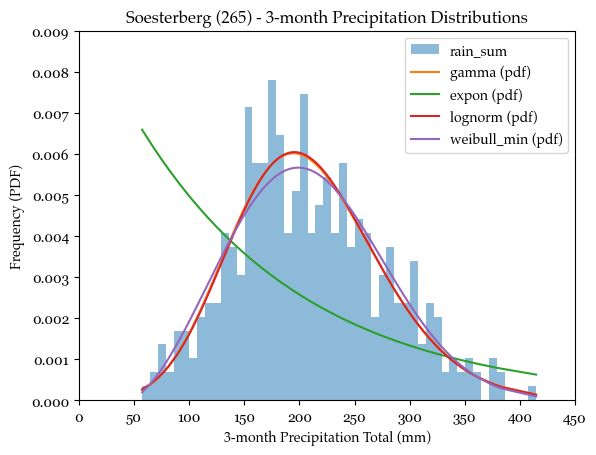

In [49]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

dists = ["gamma", "expon", "lognorm", "weibull_min"]

# Make overview of values, sorted by total rainfall
df_d_plot = df_distr.sort_values(by="rain_sum")

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              f"- {N}-month Precipitation Distributions")

# Make histogram plot of actual data
ax = df_d_plot[["rain_sum"]].plot(kind="hist", bins=50, 
                                  density=True, alpha=0.5, 
                                  label='Histogram')

# Create lines for each tested distribution's PDF
for distr in dists:
    ax.plot(df_d_plot["rain_sum"], df_d_plot[distr + "_pdf"], 
            label=distr + ' (pdf)')

# Customize title, legend and layout
ax.set_title(plot_title, **textfont)
ax.legend()

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xlabel(f"{N}-month Precipitation Total (mm)", **textfont)
ax.set_ylabel(f"{ax.get_ylabel()} (PDF)", **textfont)

plt.show()

##### Observations
The Gamma, log-normal and Weibull distributions seem to all approximate the histogram of the actual precipitation totals fairly well. 

On the other hand, the exponential distribution does not seem to make any good fit. Its shape hints towards working best for arid regions where rainfall tends to be scarce, leading even $N$-month totals to be clustered around the lowest values.

Of the three well-fitting options, the Gamma distribution function models the underlying dataset most accurately based on its $L2$-norm (Euclidean) distance to the $ECDF$ values in our example of choice.

#### Plot CDFs of all tested distribution types
Let's now take a closer visual look at the $CDF$-values of each distribution type, and compare them to the $ECDF$ of our actual precipitation sums:

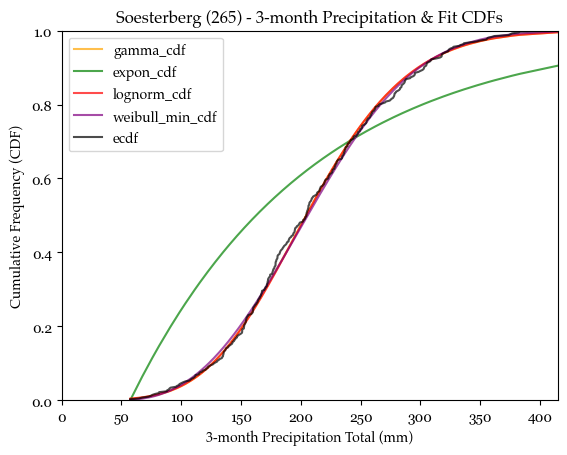

In [50]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Set distributions and colors
dists = ["gamma", "expon", "lognorm", "weibull_min"]
colors = ["orange", "green", "red", "purple", "black"]

# Create overview of CDFs only, to plot
df_c_plot = (df_distr[["rain_sum"] + [d + "_cdf" for d in dists] 
                     + ["ecdf"]].sort_values(by="rain_sum"))

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              f"- {N}-month Precipitation & Fit CDFs")

ax = df_c_plot.plot(x="rain_sum", alpha=0.7, color=colors)

# Customize title, legend and layout
ax.set_title(plot_title, **textfont)
ax.legend()

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xlabel(f"{N}-month Precipitation Total (mm)", **textfont)
ax.set_ylabel(f"Cumulative Frequency (CDF)", **textfont)

ax.set_xlim(0, df_c_plot["rain_sum"].max())
ax.set_ylim(0, 1)

plt.show()

##### Observations
From the $CDF$-based plot above, it becomes clear that Gamma, Log-Norm, and Weibull all would be proper distribution function candidates. All three approximate the $ECDF$ quite well. 

As before for the $PDF$ values, the fourth (Exponential distribution) does not provide a very good fit for our station of interest. Again, given its shape characteristics, this distribution might show better performance in arid regions.

We will continue below using the best-fit distribution for calculating the SPI index scores - Gamma in our example case.

### Section 1.4 - Use best-fit distribution to calculate SPI

#### Get SPI from taking the inverse-normal
Now that we have fitted a distribution to our precipitation totals, we can express the distribution of our dataset in a <em>continous</em> way.

In order to translate the percentiles from the best-fit distribution to the SPI, which is basically a Z-score (where $ Z = \frac{(X - \mu)}{\sigma} $), we apply the inverse-normal transformation assuming a <em>standard normal distribution</em> with $\sigma = 1$, $\mu = 0$.

Note that taking the inverse normal of the percentile scores does not mean that we are fitting an actual standard normal distribution to the dataset. It is merely a translation from the $CDF$ <em>percentiles</em> from our best-fit distribution to a Z-score. The reason for this is that Z-scores (as we will see later on) work quite intuitively to identify events of drought and wetness.

In the cell below, <code>scipy</code> is once again used to take the inverse-normal of the $CDF$ of our best-fit distribution (Gamma in the example of interest).

This procedure gives us the $N$-month SPI score, also denoted as SPI-$N$:

In [51]:
# Apply inverse normal distribution to best-fit CDF
norm_ppf = scs.norm.ppf(df_distr[f"{best_distr}_cdf"])
norm_ppf[np.isinf(norm_ppf)] = np.nan

# Now we have our SPI-N score:
df_distr[f"spi_{N}"] = norm_ppf.copy()

# Show the result
df_distr[["rain_sum", f"{best_distr}_cdf", "ecdf", f"spi_{N}"]]

,rain_sum,gamma_cdf,ecdf,spi_3
date,,,,
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.657767,0.437050
1974-09-01,303.04,0.910026,0.900485,1.340915
1974-10-01,361.86,0.979359,0.985437,2.040694
...,...,...,...,...
2008-07-01,193.71,0.436696,0.451456,-0.159351
2008-08-01,244.17,0.716140,0.713592,0.571412
2008-09-01,268.48,0.815603,0.803398,0.898733


At last - our first SPI(-$N$) score is here!

#### Plot SPI-$N$ result
In the cell below a plot to show the SPI-$N$ score as a timeseries is produced:

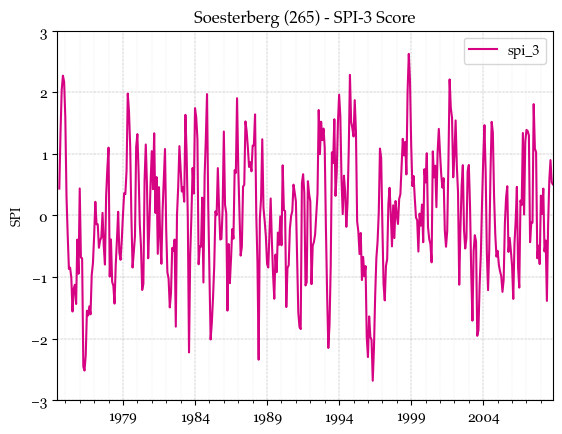

In [52]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Set distributions and colors
dists = ["gamma", "expon", "lognorm", "weibull_min"]
colors = ["orange", "green", "red", "purple", "black"]

# Create overview of CDFs only, to plot
df_c_plot = (df_distr[["rain_sum"] + [d + "_cdf" for d in dists] 
                     + ["ecdf"]].sort_values(by="rain_sum"))

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              f"- SPI-{N} Score")

ax = df_distr.reset_index().plot(x="date", y=f"spi_{N}",
                                 color="#d60482")

# Customize title, legend and layout
ax.set_title(plot_title, **textfont)
ax.legend()

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xlabel(None, **textfont)
ax.set_ylabel(f"SPI", **textfont)

# Set grids
ax.grid(which="major", color="gray", linestyle="-.", linewidth=0.25)
ax.grid(which="minor", color="lightgray", linestyle="-.", linewidth=0.15)

plt.show()

##### Observations
As expected, the SPI falls roughly in a range between $-3$ and $3$ (standard deviations $\sigma $ from the mean $\mu$) for our $412$ defined $3$-monthly periods, which should be the case for around 99.7 % of the percentile-data in the distribution.

There is a mix of dryer and wetter periods, as is expected as well.

Apparently the dryest periods (for SPI-$3$ at this chosen station) for our station of interest took place around 1976, 1988 and 1996. Meanwhile 1974, 1994 and 1998 show the top-three wettest scores.

Contrary to what I had expected, namely: a slightly higher tendency to more extreme values over time, no strong time-based pattern seems to be visually apparent.

However, what must be noted is that the SPI only captures rainfall patterns. Temperature is not a factor - contrary to for SPEI. We will also study the SPEI scores in the sections yet to come.

### Section 1.5 - Calculate all SPI scores of interest


By now we have established a method to calculate the SPI-$N$ values. 

Let's repeat this procedure for the other SPI timeframes of interest - as a reminder:
- <strong>SPI-1</strong> reflects precipitation anomalies over the past month. It is a short-term indicator sensitive to immediate changes in rainfall, often associated with surface soil moisture conditions and impacts on agriculture.
- <strong>SPI-3</strong> represents anomalies over a 3-month period, capturing seasonal precipitation trends. It’s commonly used to assess short-term agricultural drought and early hydrological impacts.
- <strong>SPI-6</strong> bridges short- and medium-term drought effects. It provides insights into soil moisture, streamflow, and reservoir levels.
- <strong>SPI-9</strong> is often tied to seasonal and medium-term water resource availability, such as impacts on larger reservoirs and river systems.
- <strong>SPI-12</strong> reflects long-term hydrological conditions and water storage. Useful for understanding drought impacts on groundwater and large-scale water resources.
- <strong>SPI-24</strong> captures anomalies over a 2-year period, focusing on prolonged droughts and long-term groundwater and aquifer recharge impacts.

#### Calculate SPIs

In helper script <code>knmi_spi_utils.py</code>, convenience functions were written to calculate the SPI for all timeframes listed above. For each timeframe, a best-fit distribution is found, after which the found percentiles are translated to Z-scores: our SPIs. 

The same method as in Section 1.4 is used. Let's run the cell below to make it happen:

In [53]:
# Collect all SPI series for one location
df_rain_data = (knmi_spi_utils
                .measured_imputed_to_one_series(df_rain_all, "rain_sum"))
df_m_spi = knmi_spi_utils.calculate_nmonth_spi(df_rain_data, "rain_sum")

df_m_spi

,rain_sum,is_imputed,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24
date,,,,,,,,
1974-06-01,55.80,0.000000,-0.256245,NaN,NaN,NaN,NaN,NaN
1974-07-01,84.02,0.000000,0.458244,NaN,NaN,NaN,NaN,NaN
1974-08-01,94.68,0.000000,0.706292,0.437050,NaN,NaN,NaN,NaN
1974-09-01,124.34,0.000000,1.359695,1.340915,NaN,NaN,NaN,NaN
1974-10-01,142.84,0.000000,1.748429,2.040694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.096774,0.956454,-0.159351,-0.530762,-0.294024,-0.557647,0.929963
2008-08-01,99.16,1.000000,0.808084,0.571412,0.089484,0.026817,-0.206370,0.556421
2008-09-01,63.53,1.000000,-0.049587,0.898733,-0.240566,-0.008622,-0.355838,0.793850


#### Plot full SPI result
Time to bring the SPI scores to life by visualizing them:

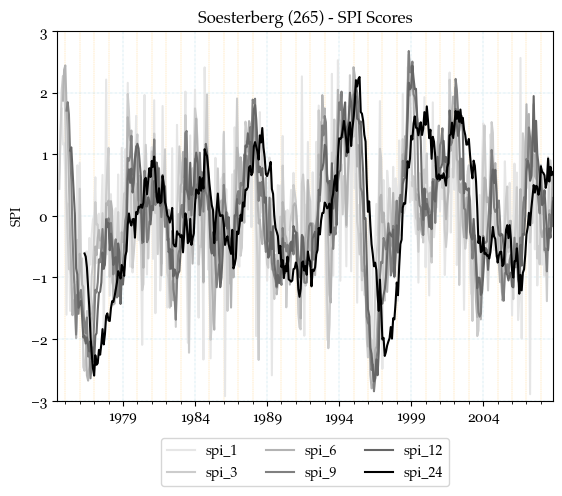

In [54]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Set colors
colors = ["0.9", "0.8", "0.7", "0.5", "0.4", "0"]

# Create Axes to plot SPI scores on
ax = (df_m_spi.loc[:, df_m_spi.columns.str.contains("spi")]
      .plot(color=colors))

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              f"- SPI Scores")

# Customize title, legend and layout
ax.set_title(plot_title, **textfont)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25),
          ncols=3)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xlabel(None, **textfont)
ax.set_ylabel(f"SPI", **textfont)

# Set Z-score (SPI) limits
ax.set_ylim(-3, 3)

# Set grids
ax.grid(which="major", color="lightblue", linestyle="-.", linewidth=0.3)
ax.grid(which="minor", color="orange", linestyle="-.", linewidth=0.15)

plt.show()

#### Observations
In the plot above the SPI scores for our station of interest are shown. The shorter the SPI timeframe, the lighter the greyscale tint used for marking timeseries values. 

The SPI-1, -3 and -6 seem to have a substantial degree of seasonal effects (one-year peaks and valleys). The longer timeframes indicate less strong short-term oscillations: periods of extensive drought (low SPI) and wetness (high SPI) tend to occur less frequently.

Another interesting observation is that the long-term SPI (-12 and -24) scores tend to have slightly less extreme values during pronounced drought and wetness compared to their shorter-term counterparts. When such an event in the long-term series does occur, however, it lags behind the more short-term based extreme events, but also seems to persist for a longer (usually multi-year) period. This happens for instance during the drought events of the late 70s and late 90s, as seen from the chart above.

Let's zoom into the drought and wetness events in more detail below.

### Section 1.6 - Get dry and wet events from SPI scores

Another convenient property of the standardized nature of the SPI is that it can be used to mark and quantify events of drought and wetness. 

We will see this in action in this section.

#### Implementation definition in this work
Events are defined as subsequent periods in which the SPI-$N$ score is at least as far from the mean as the event threshold. This means, for example, that a <em>severe wetness</em> event starts in the first month with a score above $1.5$, and ends whenever the score starts falling below $1.5$ again.

Events are marked by the following thresholds in line with their WMO-definitions:
- <em>Extreme wetness</em>: SPI-$N \ \geq \ 2.0$
- <em>Severe wetness</em>: SPI-$N \ \geq \ 1.5$
- <em>Wetness</em>: SPI-$N \ \geq \ 1.0$
- <em>Drought</em>: SPI-$N \ \leq \ -1.0$ 
- <em>Severe drought</em>: SPI-$N \ \leq \ -1.5$
- <em>Extreme drought</em>: SPI-$N \ \leq \ -2.0$

The magnitude of each event ($M_{event}$) is defined and calculated as the (absolute) sum of all SPI-$N$ scores during that event:
$$ M_{event} = \sum_{t \ = \ start_{event}}^{t \ = \ end_{event}}|SPI_{N}(t)| $$

##### Words of caution
- Note that in the examples of this Jupyter Notebook we can only reasonably compare the magnitudes of the <u>same type of event</u> (e.g.: rank the events of <em>severe drought</em> by magnitude). Reason for this is that more extreme events are cut off more quickly than more regular events (since their thresholds are at less extreme points to start with).
- Drought and wetness events need a defined <em>timescale</em> of $N$ months. This means that an event is not defined as a universal event, but only in terms of their $N$-month timeframe. In other words: an event on a shorter timeframe does not necessarily result in similar events of the same time on longer timeframes (and vice versa).

#### Calculation time!
Let's recap how the DataFrame overview of SPI scores looks like:

In [55]:
df_m_spi

,rain_sum,is_imputed,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24
date,,,,,,,,
1974-06-01,55.80,0.000000,-0.256245,NaN,NaN,NaN,NaN,NaN
1974-07-01,84.02,0.000000,0.458244,NaN,NaN,NaN,NaN,NaN
1974-08-01,94.68,0.000000,0.706292,0.437050,NaN,NaN,NaN,NaN
1974-09-01,124.34,0.000000,1.359695,1.340915,NaN,NaN,NaN,NaN
1974-10-01,142.84,0.000000,1.748429,2.040694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.096774,0.956454,-0.159351,-0.530762,-0.294024,-0.557647,0.929963
2008-08-01,99.16,1.000000,0.808084,0.571412,0.089484,0.026817,-0.206370,0.556421
2008-09-01,63.53,1.000000,-0.049587,0.898733,-0.240566,-0.008622,-0.355838,0.793850


##### Get overview of events

A helper function was written in script <code>knmi_spi_utils.py</code>. That function enables us to label the start and end periods of all types of events listed above, given a certain timeframe ($N$-month-based SPI), and calculates the magnitude of the event by summing all SPI scores while that event lasts.

In the cell below we make a call to the aforementioned function to get an overview of our events of interest:

In [56]:
spi_timeframe_m = 12
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spi, f"spi_{spi_timeframe_m}", "drought"))
events_df.sort_values(f"drought_spi_{spi_timeframe_m}_magnitude", ascending=False)

,drought_spi_12_first_start_idx,drought_spi_12_last_start_idx,drought_spi_12_magnitude,drought_spi_12_duration
0,1975-12-01,1977-07-01,36.06,20
7,1996-01-01,1997-04-01,30.24,16
8,2003-08-01,2003-12-01,5.72,5
10,2006-01-01,2006-02-01,2.31,2
4,1985-10-01,1985-11-01,2.17,2
6,1989-11-01,1989-12-01,2.10,2
1,1978-11-01,1978-11-01,1.43,1
11,2006-07-01,2006-07-01,1.19,1
5,1989-09-01,1989-09-01,1.14,1
2,1979-01-01,1979-01-01,1.12,1


Great! 

We have hereby marked historic drought events based on an $N$-month timeframe, and even ranked them on intensity.

#### Observations
From a $12$-month perspective (as in the original example) the most pronounced drought periods for our station of interest lasted from:
1. Late-1975 until the summer of 1977
2. Early 1996 until the late spring of 1997
3. In the late summer of 2003, until the year's end

The other drought events in the list are of a relatively short nature, up to 2 months. 

Apparently it has been the relative norm for our station of interest that 12-month-based drought events do not persist long. This is probably because a 12-month-based drought requires two subsequent quite dry years in a row, which is a much rarer occurrence compared to having a single dry year.

#### Shorter timespan-based events
Let's try the same with a shorter timespan of 3 months:

In [57]:
spi_timeframe_m = 3
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spi, f"spi_{spi_timeframe_m}", "drought"))
events_df.sort_values(f"drought_spi_{spi_timeframe_m}_magnitude", ascending=False)

,drought_spi_3_first_start_idx,drought_spi_3_last_start_idx,drought_spi_3_magnitude,drought_spi_3_duration
19,1995-12-01,1996-07-01,16.06,8
1,1976-04-01,1976-10-01,13.49,7
0,1975-06-01,1975-10-01,6.32,5
14,1991-03-01,1991-05-01,5.23,3
17,1993-03-01,1993-05-01,5.20,3
8,1985-02-01,1985-04-01,5.09,3
23,2003-08-01,2003-10-01,4.94,3
4,1982-03-01,1982-05-01,3.78,3
2,1978-04-01,1978-06-01,3.65,3
20,1997-02-01,1997-03-01,2.49,2


#### Observations
As expected, a lot more events show up for our shorter timeframe (capturing within-season patterns).

When comparing the event dates to their 12-month counterparts, you may note that periods of extended drought (e.g. 1975-76 and 1995-96) have a much earlier start date than the long-term events.

This means that for drought monitoring it is key to always consider a mix of SPI-$N$ scores in your analysis. A shorter-term SPI-$N$ event may namely be a signal for an impending event affecting the longer-term water reservoirs later on.

#### Notes

Drought event definitions may differ between sources. For instance, [this UNFCCC report](https://unfccc.int/files/adaptation/application/pdf/supplement_nap_wmo_cop21.pdf) a drought event continues until the SPI passes the 0.0 mark completely. 

Meanwhile, in this notebook and in the supporting Python scripts, the end of a drought event is already marked when the SPI gets closer to the mean than -1.0.

# Section 2: SPEI analysis for a station with missing data

### Introduction

Up to this point we have only analyzed the SPI scores for a weather station. Although the SPI is widely used, it has the limitation that it only provides a partial picture of the complete water balance by merely considering the influx side (precipitation). 

A more complete metric that considers both the influx and outflux components of the water balance was coined by [Vicente-Serrano et al. (2010)](https://doi.org/10.1175/2009JCLI2909.1): the <em>Standardized Precipitation Evapotranspiration Index</em> or SPEI.

Besides offering a fuller picture of the complete water balance, the SPEI (contrary to the SPI) has an indirect link to temperature through its evaporation component. This makes it a very suitable metric for long-term climatic studies where temperature is often a critical input parameter.

### Theory to practice

In this section we will analyze the same station of interest as in Section 1 for the SPI. 

Conveniently, the results that we obtained from that section already provide us with the precipitation data that are required as input for the SPEI calculation.

#### Reference evaporation


KNMI calculates the so-called <em>reference evaporation</em> in the majority of automated weather stations using [the Makkink formula as in this link](https://nl.wikipedia.org/wiki/Referentie-gewasverdamping). 

Note that KNMI only calculates the reference evaporation if all formula inputs (e.g. temperature, global irradiance and wind speed) are also measured at the same station.

### Retrieve and clean evaporation data

The process for retrieving KNMI's (reference) evaporation data is virtually the same as for precipitation as we did earlier on. We only need to change the parameter code for the request.

We do so in the cell below by making a call to a helper function from <code>knmi_spi_utils.py</code>:

In [58]:
# Get (cleaned) daily reference evaporation from KNMI
df_evap = (knmi_spi_utils
           .get_measured_stn_param_values(stn_code=STN_CODE,
                                          param_col="evap_ref"))

### Create imputation dataset (if needed)

#### Fetch years with missing evaporation data

In the cell(s) below we retrieve the full years for which any missing day was found:

In [59]:
# Find years to create imputation dataset for (if any)
(try_impute, years_to_impute) = (knmi_spi_utils
                                 .check_years_to_impute(
                                     df_evap, param_col="evap_ref"))

print(years_to_impute)

[1993, 2005, 2007, 2008]


#### Find highly-correlating other evaporation stations

Now we try to find the highest-correlating other evaporation stations (if any) to use for our imputation later on:

In [60]:
# Find imputation stations for evaporation (if any)
if try_impute:
    (run_impute, impute_stn_codes, df_imp) = (
        knmi_spi_utils.find_imputation_stations(
            stn_code = STN_CODE, 
            years_to_impute = years_to_impute,
            param_col = "evap_ref")
    )

Let's only keep the highest-correlating other evaporation stations and the partly-NaN evaporation series from our station of interest:

In [61]:
if run_impute:
    df_imp = (knmi_spi_utils
              .filter_datacols_to_impute(
                  df_imp, STN_CODE, impute_stn_codes))
else:
    df_imp = pd.DataFrame()

df_imp

station_code,265,260,348,356,275,269
date,,,,,,
1993-01-01,NaN,0.4,0.3,0.3,0.4,0.2
1993-01-02,NaN,0.4,0.4,0.4,0.3,0.4
1993-01-03,NaN,0.3,0.3,0.3,0.3,0.3
1993-01-04,NaN,0.2,0.2,0.2,0.2,0.2
1993-01-05,NaN,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...
2008-12-27,NaN,0.4,0.4,0.4,0.4,0.3
2008-12-28,NaN,0.4,0.4,0.5,0.4,0.4
2008-12-29,NaN,0.3,0.4,0.4,0.4,0.4


#### Find best imputation model and run it on the evaporation data

Just as for precipitation in Section 1, we will use a multitude of models to find the best one to use for imputation. 

Again we score the imputation models on 25 % randomly missing data from our target column, and set the minimally required $R^{2}$ threshold at $0.50$. Both these parameters can be set dynamically in the function called in the cell below, so feel free to change them if desired.

In the function called in the cell below, the best-scoring imputer model will also already be run on the full imputation dataset.

In [62]:
if run_impute:
    df_imputed = knmi_spi_utils.impute_vals_from_targetcol(df_imp, STN_CODE, "evap_ref")
else:
    df_imputed = pd.DataFrame()

df_imputed

Testing 'LinearRegression' model(s):
  Params: {}, MSE: 0.0169, R^2: 0.9898, score: 0.0598
Testing 'Ridge' model(s):
  Params: {'alpha': 0.1}, MSE: 0.0168, R^2: 0.9898, score: 0.0597
  Params: {'alpha': 1.0}, MSE: 0.0163, R^2: 0.9901, score: 0.0590
  Params: {'alpha': 10.0}, MSE: 0.0152, R^2: 0.9908, score: 0.0570
Testing 'Lasso' model(s):
  Params: {'alpha': 0.001}, MSE: 0.0168, R^2: 0.9898, score: 0.0597
  Params: {'alpha': 0.01}, MSE: 0.0167, R^2: 0.9899, score: 0.0595
  Params: {'alpha': 0.1}, MSE: 0.0196, R^2: 0.9881, score: 0.0641
  Params: {'alpha': 1.0}, MSE: 0.4843, R^2: 0.7066, score: 0.2013
  Params: {'alpha': 10.0}, MSE: 1.6633, R^2: -0.0075, score: 0.1411
Testing 'Random Forest' model(s):
  Params: {'max_depth': 3, 'n_estimators': 10}, MSE: 0.0471, R^2: 0.9715, score: 0.0942
  Params: {'max_depth': 3, 'n_estimators': 20}, MSE: 0.0430, R^2: 0.9740, score: 0.0906
  Params: {'max_depth': 3, 'n_estimators': 50}, MSE: 0.0443, R^2: 0.9732, score: 0.0918
  Params: {'max_depth': 3

station_code,date,evap_ref_imputed
0,1993-01-01,0.332221
1,1993-01-02,0.360253
2,1993-01-03,0.279513
3,1993-01-04,0.180015
4,1993-01-05,0.080517
...,...,...
638,2008-12-27,0.366206
639,2008-12-28,0.387095
640,2008-12-29,0.332255
641,2008-12-30,0.379010


##### Observations
Apparently a relatively simple Ridge model scores best for our dataset of interest. 

Note from the output of the cell above that a baseline linear regression model would already have given us a score that is virtually as good as the best one for our example of interest. 

Sometimes simplicity actually wins!

#### Merge measured and imputed evaporation datasets to one column

Now it is time to merge the measured (observed) and imputed evaporation datasets to a single timeseries:

In [63]:
if not run_impute:
    df_imputed = None

df_evap_all = knmi_spi_utils.merge_measured_and_imputed_data(df_evap, 
                                                             df_imputed, 
                                                             "evap_ref")
df_evap_all

,date,evap_ref,evap_ref_imputed
0,1993-10-01,NaN,0.64
1,1993-10-02,NaN,1.17
2,1993-10-03,NaN,0.22
3,1993-10-04,NaN,0.95
4,1993-10-05,NaN,1.02
...,...,...,...
5535,2008-11-26,NaN,0.19
5536,2008-11-27,NaN,0.08
5537,2008-11-28,NaN,0.11
5538,2008-11-29,NaN,0.27


In [64]:
# Evap data to single timeseries
df_evap_data = (knmi_spi_utils
                .measured_imputed_to_one_series(df_evap_all, "evap_ref"))
df_evap_data

,date,evap_ref,is_imputed
0,1993-10-01,0.64,True
1,1993-10-02,1.17,True
2,1993-10-03,0.22,True
3,1993-10-04,0.95,True
4,1993-10-05,1.02,True
...,...,...,...
5535,2008-11-26,0.19,True
5536,2008-11-27,0.08,True
5537,2008-11-28,0.11,True
5538,2008-11-29,0.27,True


#### Merge measured and imputed precipitation data to one column

We repeat the same column-merging procedure for the precipitation dataset that we will need below:

In [65]:
# Rain data (from Section 1) to single timeseries
df_rain_data = (knmi_spi_utils
                .measured_imputed_to_one_series(df_rain_all, "rain_sum"))
df_rain_data

,date,rain_sum,is_imputed
0,1974-06-01,0.30,False
1,1974-06-02,0.30,False
2,1974-06-03,7.40,False
3,1974-06-04,0.00,False
4,1974-06-05,0.00,False
...,...,...,...
12597,2008-11-26,0.69,True
12598,2008-11-27,0.10,True
12599,2008-11-28,0.01,True
12600,2008-11-29,0.28,True


### Combine precipitation and evaporation datasets

By subtracting evaporation from precipitation we obtain the <em>net precipitation</em> or <em>precipitation excess</em> (which is the opposite of the precipitation deficit).

This <em>net precipitation</em> forms the input for the SPEI-$N$ calculations in the next step.

In [66]:
df_pcp_data = df_rain_data.merge(df_evap_data, on="date", how="left")

# Average imputed-data counts of the two cols as aggregated row metric
imp_cols = ["is_imputed_x", "is_imputed_y"]
df_pcp_data["is_imputed"] = (df_pcp_data[imp_cols].astype(float)
                             .sum(axis=1, skipna=False) / len(imp_cols))

# Calculate net precipitation (rain minus evap)
df_pcp_data["rain_min_evap"] = (df_pcp_data["rain_sum"] 
                                - df_pcp_data["evap_ref"])

# Only keep columns of interest
keep_cols = ["date", "rain_min_evap", "is_imputed"]
df_pcp_data = df_pcp_data[[col for col in keep_cols]]

# Show the result
df_pcp_data

,date,rain_min_evap,is_imputed
0,1974-06-01,NaN,NaN
1,1974-06-02,NaN,NaN
2,1974-06-03,NaN,NaN
3,1974-06-04,NaN,NaN
4,1974-06-05,NaN,NaN
...,...,...,...
12597,2008-11-26,0.50,1.0
12598,2008-11-27,0.02,1.0
12599,2008-11-28,-0.10,1.0
12600,2008-11-29,0.01,1.0


### Calculate SPEI-$N$ scores

Since we now we have the net precipitation available to us, we can go on to calculate the $N$-month-based SPEI scores.

The only additional point of consideration in the underlying code run in the cell below, is that not all distributions (Gamma, Exponential, Log-normal, Weibull) that we will test-fit allow for negative values. This was not a concern for SPI, but now it is, as sometimes evaporation will exceed precipitation (most so on warm, sunny summer days).

This means that, for fitting the distributions as earlier on for SPI, we need to offset all data by the minimum value to fit a distribution and finally use the inverse of this offset to obtain our final result.

This is all done in the helper function from script <code>knmi_spi_utils.py</code> that is called in the cell below:

In [67]:
# Calculate best-fit distributions & SPEI scores from net precip
df_m_spei = (knmi_spi_utils
             .calculate_nmonth_spei(df_pcp_data, "rain_min_evap"))

In [68]:
# Show the result
df_m_spei

,rain_min_evap,is_imputed,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24
date,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,16.26,0.096774,-0.084860,-1.372205,-1.030008,-0.296724,-0.628147,0.654566
2008-08-01,27.23,1.000000,0.106849,-0.683525,-0.898317,-0.380681,-0.278435,0.291901
2008-09-01,14.85,1.000000,-0.213211,-0.079004,-1.276102,-0.676360,-0.427452,0.547217


Amazing! We have obtained the $N$-month-based SPEI scores for our station of interest.

### Plot SPEI-$N$ scores

Let's create a chart to get a better view of the calculated SPEI-$N$ scores:~

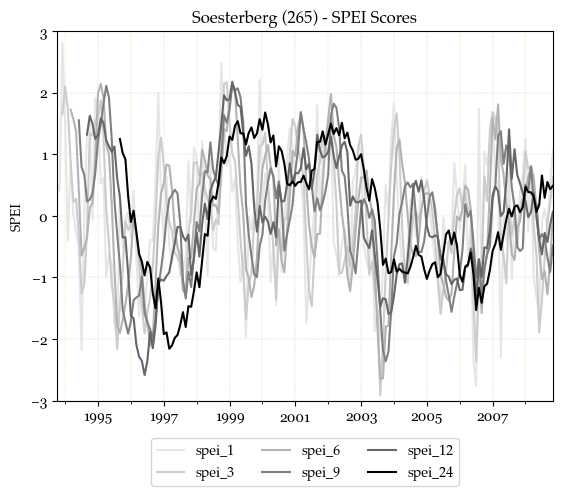

In [69]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Set colors
colors = ["0.9", "0.8", "0.7", "0.5", "0.4", "0"]

# Create Axes to plot SPI scores on
ax = (df_m_spei.loc[:, df_m_spei.columns.str.contains("spei")]
      .dropna(how="all").plot(color=colors))

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              f"- SPEI Scores")

# Customize title, legend and layout
ax.set_title(plot_title, **textfont)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25),
          ncols=3)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xlabel(None, **textfont)
ax.set_ylabel(f"SPEI", **textfont)

# Set Z-score (SPEI) limits
ax.set_ylim(-3, 3)

# Set grids
ax.grid(which="major", color="lightblue", linestyle="-.", linewidth=0.3)
ax.grid(which="minor", color="orange", linestyle="-.", linewidth=0.15)

plt.show()

#### Observations

The patterns for our station of interest seem to broadly match those that we have identified for the SPI scores earlier.

One difference is that major short-term droughts can now be identified for late 2003 and early 2006, besides the 1996-1997 drought that was one of the two major SPI-based drought events at the end of Section 1.

Contrary to in the SPI example for our same station of interest, the post-2000 period seems to have more pronounced periods of drought now - most so for the shorter-term SPEI scores. 

However, we must also take into consideration that we are only observing a solid 15 years of SPEI data here. In contrast, the SPI dataset for the same station spans almost 35 years. The reason for this is that evaporation has only been available on that location since the early 90s. 

As the 15-year timeframe is relatively short, we must proceed with caution when interpreting the results.

Unfortunately some of the more recent years (post-2010) are not available at our meteorological station of interest. Therefore we will re-run the SPEI analysis for KNMI's most-complete weather station at their HQ in De Bilt in the following section. That station is, by the way, less than 15 km away from our initial station of interest.

### Get $N$-month-based SPEI drought events

From the code in the cell below we can identify the $N$-month SPEI-based drought (and/or wetness) events for this weather station:

In [70]:
spei_timeframe_m = 6
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spei, f"spei_{spei_timeframe_m}", "severe_drought"))
events_df.sort_values(f"severe_drought_spei_{spei_timeframe_m}_magnitude", ascending=False)

,severe_drought_spei_6_first_start_idx,severe_drought_spei_6_last_start_idx,severe_drought_spei_6_magnitude,severe_drought_spei_6_duration
2,2003-07-01,2003-11-01,10.71,5
1,1996-07-01,1996-09-01,5.81,3
0,1995-08-01,1995-10-01,5.37,3
3,2006-09-01,2006-09-01,1.58,1


#### Observations
Again, and contrary to the SPI event examples in Section 1, the summer of 2003 shows up as the most intense period of drought instead of the 1995/1996 drought periods.

Apparently the evaporation component must have been relatively strong in 2003 because of the high temperatures and extensive sunshine.

## Section 3: SPEI long-term analysis for De Bilt

### Introduction

My main interest in setting up this drought analysis was raised by the intense drought events of 2018 and 2019. During late summer 2019 I was working for one of the Dutch regional-level water councils. At that time there were substantial internal concerns about having two consecutive summers with (extremely) low water levels and problems for agriculture.

Soesterberg, the station of interest in the previous sections, provided a great example of a weather station with missing data and lessons on how to deal with an incomplete dataset. However, that weather station was decommissioned after 2008. Because of that, the more recent years are missing.

To get a more long-term and up-to-date view of matters, we will run the SPEI-based analysis for KNMI's flagship weather station in De Bilt now.

### Main question
The main underlying question for this analysis is the following: <em>Have Dutch extreme droughts and/or wetness become more frequent and intense recently?</em>

### Retrieve and clean evaporation data

In [71]:
# Set KNMI station code for The Bilt (260)
NEW_STN_CODE = 260

In [72]:
# Validate station code; print location name
new_stn = (knmi_spi_utils.validate_station_code(260))
print(new_stn["NAME"][0])

De Bilt


The process for retrieving KNMI's (reference) evaporation and precipitation data is the same as we did in the earlier sections. 

We do so in the cells below by making a call to a helper function from <code>knmi_spi_utils.py</code>:

In [73]:
# Obtain precipitation and evaporation data from KNMI
df_rain = (knmi_spi_utils
           .get_measured_stn_param_values(stn_code=NEW_STN_CODE,
                                          param_col="rain_sum"))
df_evap = (knmi_spi_utils
           .get_measured_stn_param_values(stn_code=NEW_STN_CODE,
                                          param_col="evap_ref"))

### Impute missing data in dataset (if needed and possible)
A full imputation workflow is run for our new example of interest in the code block below:

In [74]:
# Run imputation workflow
df_rain_sel = knmi_spi_utils.imputation_workflow(df_rain, "rain_sum", NEW_STN_CODE,
                                                 print_progress = False)
df_evap_sel = knmi_spi_utils.imputation_workflow(df_evap, "evap_ref", NEW_STN_CODE,
                                                 print_progress = True)

No matching stations found for MICE imputation; use another method or drop missing data instead of imputing.


### Combine precipitation and evaporation datasets

By subtracting evaporation from precipitation we obtain the <em>net precipitation</em> or <em>precipitation excess</em> (which is the opposite of the precipitation deficit).

This <em>net precipitation</em> forms the input for the SPEI-$N$ calculations in the next step.

In [75]:
# Show cleaned, imputed rain dataset
df_rain_sel

,date,rain_sum,is_imputed
0,1906-01-01,0.000,False
1,1906-01-02,0.000,False
2,1906-01-03,0.000,False
3,1906-01-04,3.600,False
4,1906-01-05,13.400,False
...,...,...,...
43460,2024-12-27,0.000,False
43461,2024-12-28,0.000,False
43462,2024-12-29,0.700,False
43463,2024-12-30,0.200,False


In [76]:
# Show cleaned, imputed evap dataset
df_evap_sel

,date,evap_ref,is_imputed
0,1957-07-01,3.6,False
1,1957-07-02,4.2,False
2,1957-07-03,3.3,False
3,1957-07-04,3.8,False
4,1957-07-05,3.7,False
...,...,...,...
24651,2024-12-27,0.2,False
24652,2024-12-28,0.1,False
24653,2024-12-29,0.1,False
24654,2024-12-30,0.1,False


In [77]:
# Calculate series of net precipitation (precip - evap)
df_pcp_sel = (knmi_spi_utils
              .calc_rain_min_evap_df(df_rain_sel, df_evap_sel))

In [78]:
# Show the (precip - evap) result
df_pcp_sel

,date,rain_min_evap,is_imputed
0,1906-01-01,NaN,NaN
1,1906-01-02,NaN,NaN
2,1906-01-03,NaN,NaN
3,1906-01-04,NaN,NaN
4,1906-01-05,NaN,NaN
...,...,...,...
43460,2024-12-27,-0.200,0.0
43461,2024-12-28,-0.100,0.0
43462,2024-12-29,0.600,0.0
43463,2024-12-30,0.100,0.0


### Calculate SPEI-$N$ scores

Since we now we have the net precipitation available to us, we can go on to calculate the $N$-month-based SPEI scores.

The only additional point of consideration in the underlying code run in the cell below, is that not all distributions (Gamma, Exponential, Log-normal, Weibull) that we will test-fit allow for negative values. This was not a concern for SPI, but now it is, as sometimes evaporation will exceed precipitation (most so on warm, sunny summer days).

This means that, for fitting the distributions as earlier on for SPI, we need to offset all data by the minimum value to fit a distribution and finally use the inverse of this offset to obtain our final result.

Just as for Section 2, this is all done in the helper function from script <code>knmi_spi_utils.py</code> that is called in the cell below:

In [79]:
# Calculate best-fit distributions & SPEI scores from net precip
df_m_spei = (knmi_spi_utils
             .calculate_nmonth_spei(df_pcp_sel, "rain_min_evap"))

In [80]:
# Show the result: SPI-N scores
df_m_spei

,rain_min_evap,is_imputed,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24
date,,,,,,,,
1906-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-01,-56.275,0.0,-1.373967,-1.413389,-0.713511,0.696289,2.106480,1.590319
2024-09-01,97.150,0.0,1.284063,-0.297969,-0.321785,0.510309,2.676583,1.754363
2024-10-01,12.650,0.0,-0.115390,-0.099340,-0.418360,0.094064,1.740964,1.780069


Great! We have obtained the $N$-month-based SPEI scores for our new station of interest.

### Plot SPEI-$N$ scores

Let's again create a plot to get a better view of the calculated SPEI-$N$ scores:

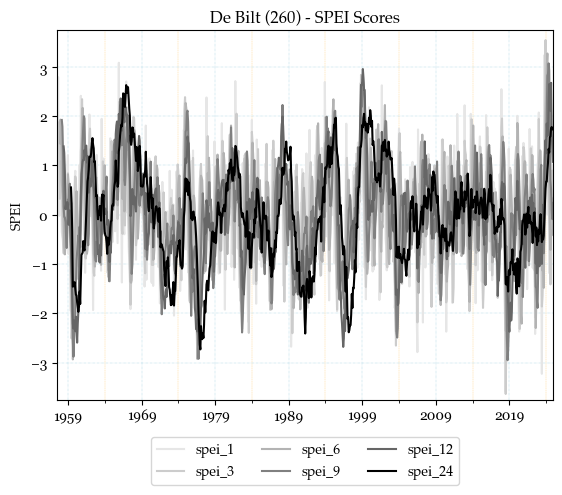

In [81]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Set colors
colors = ["0.9", "0.8", "0.7", "0.5", "0.4", "0"]

# Create Axes to plot SPI scores on
ax = (df_m_spei.loc[:, df_m_spei.columns.str.contains("spei")]
      .dropna(how="all").plot(color=colors))

# Dynamically generate title for plot
plot_title = (f"{new_stn["NAME"][0]} ({new_stn["STN"][0]}) "
              f"- SPEI Scores")

# Customize title, legend and layout
ax.set_title(plot_title, **textfont)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25),
          ncols=3)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xlabel(None, **textfont)
ax.set_ylabel(f"SPEI", **textfont)

# Set Z-score (SPEI) limits
ax.set_ylim(-3.75, 3.75)

# Set grids
ax.grid(which="major", color="lightblue", linestyle="-.", linewidth=0.3)
ax.grid(which="minor", color="orange", linestyle="-.", linewidth=0.15)

plt.show()

#### Observations

Noteworthy is that all "sigma-3+" (absolute Z-score more than 3) events took place after 2017: one extremely dry event around 2018 and an extremely wet event around 2024.

Generally it seems like the short-term SPEI scores have more intense oscillations from high- to low-SPEI spikes for the more recent years. Interestingly enough the longer-term SPEI scores (12- and 24-month) seem to center more around zero for the recent years, with the ongoing wetness event of 2023-24 as only major exception.

In other words, the SPEI timeseries for De Bilt seem to indicate more thorough seasonal peaks and valleys for the more recent years. Perhaps this could be a signal for growing differences between drier summers and wetter winters. 

On the other side of the coin, the multi-year pattern (SPEI-12 and -24) generally looks surprisingly stable for the more recent years, with the exception of the extreme wet spell during 2023/24.

#### Lessons from the past?
What I greatly appreciate about plotting these SP(E)I scores is that it is also possible to identify extreme events from the past. 

It would be interesting, for instance, to trace back which measures were taken in e.g. 1959 and 1975 to mitigate drought-induced challenges for crops, soils, and bodies of water. Similarly so for the extreme wet event around 1999.

### Get $N$-month-based SPEI drought events

From the code in the cell below we can identify the $N$-month SPEI-based drought (and/or wetness) events for this weather station:

In [82]:
spei_timeframe_m = 3
event_code = "severe_drought"
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spei, 
                                       f"spei_{spei_timeframe_m}",
                                       f"{event_code}"))

sort_col = f"{event_code}_spei_{spei_timeframe_m}_magnitude"
events_df.sort_values(sort_col, ascending=False)

,severe_drought_spei_3_first_start_idx,severe_drought_spei_3_last_start_idx,severe_drought_spei_3_magnitude,severe_drought_spei_3_duration
26,2018-06-01,2018-09-01,9.96,4
5,1976-05-01,1976-09-01,9.65,5
0,1959-06-01,1959-09-01,8.55,4
17,2003-07-01,2003-09-01,6.19,3
27,2020-05-01,2020-07-01,6.02,3
11,1989-06-01,1989-08-01,5.65,3
9,1986-06-01,1986-08-01,5.09,3
4,1975-07-01,1975-09-01,4.95,3
28,2022-07-01,2022-08-01,3.84,2
29,2023-06-01,2023-07-01,3.52,2


#### Observations
From a 3-month severe drought ($SPEI \leq -1.5$) perspective, the summer drought of 2018 stands out. Its magnitude is larger than the severe drought of 1976 even though the event itself has a shorter duration. 

Also noteworthy is that the recent years of 2020, 2022 and 2023 are represented within the top-10 of severe drought events in the table above.

### Plot heatmaps of $N$-month-based SPEI scores

Instead of visualizing the insights in timeseries and tables, let's map each month's SPEI-$N$ score using a color code instead. In this way we can see the history of drought and wetness for a weather station in one go.

We will categorize the SPEI-$N$ scores using colored labels according to their WMO definitions:
- <em><span style="background-color:#1953b7">&nbsp;&nbsp;&nbsp;</span> Extreme wetness:</em> SPEI-$N \ \geq \ 2.0$
- <em><span style="background-color:#38a1f7">&nbsp;&nbsp;&nbsp;</span> Severe wetness:</em> SPEI-$N \ \geq \ 1.5$
- <em><span style="background-color:#daedff">&nbsp;&nbsp;&nbsp;</span> Wetness:</em> SPEI-$N \ \geq \ 1.0$
- <em><span style="background-color:#fde069">&nbsp;&nbsp;&nbsp;</span> Drought:</em> SPEI-$N \ \leq \ -1.0$ 
- <em><span style="background-color:#fb7936">&nbsp;&nbsp;&nbsp;</span> Severe drought:</em> SPEI-$N \ \leq \ -1.5$
- <em><span style="background-color:#c1251b">&nbsp;&nbsp;&nbsp;</span> Extreme drought:</em> SPEI-$N \ \leq \ -2.0$

Indexes around the mean ($|SPEI_{N}| \ \leq \ 1.0 $) will be shown in white, while the most extreme events ($|SPEI_{N}| \ \geq \ 3.0 $) will have the darkest tints of their respective colors.

#### Mark month and year index of SPEI scores
In order to construct the desired heatmap visualization, we will first need to add month and year labels to the DataFrame of SPEI-$N$ scores. 

These will form our later rows and columns within the heatmap.

In [83]:
# Safe-copy DataFrame
df_m_spei_only = df_m_spei.copy()

# Only keep SPEI-related columns
keep_cols = df_m_spei_only.columns.str.contains("spei")

# Drop any full-NaN rows from the dataset
df_m_spei_only =(df_m_spei_only
                 .loc[:, keep_cols].dropna(how="all"))

# Add columns for month and year
df_m_spei_only["month"] = df_m_spei_only.index.month
df_m_spei_only["year"] = df_m_spei_only.index.year

In [84]:
df_m_spei_only

,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24,month,year
date,,,,,,,,
1957-07-01,-0.000430,NaN,NaN,NaN,NaN,NaN,7,1957
1957-08-01,1.146221,NaN,NaN,NaN,NaN,NaN,8,1957
1957-09-01,2.792563,1.783387,NaN,NaN,NaN,NaN,9,1957
1957-10-01,0.182129,1.876742,NaN,NaN,NaN,NaN,10,1957
1957-11-01,-0.019732,1.298980,NaN,NaN,NaN,NaN,11,1957
...,...,...,...,...,...,...,...,...
2024-08-01,-1.373967,-1.413389,-0.713511,0.696289,2.106480,1.590319,8,2024
2024-09-01,1.284063,-0.297969,-0.321785,0.510309,2.676583,1.754363,9,2024
2024-10-01,-0.115390,-0.099340,-0.418360,0.094064,1.740964,1.780069,10,2024


#### Plot the SPEI-$N$ category data in a heatmap

A helper function was written in script <code>knmi_meteo_visualize</code> to convert the SPEI-$N$ data to a heatmap plot.

Run the cells below to generate the heatmap for each SPEI-$N$ score of interest.

In [85]:
def generate_spei_heatmap_plot(stn, N_months):
    """Generate SPEI heatmap plot."""
    # Dynamically set plot title and target SPEI column
    plot_title = f"{stn["NAME"][0]} ({stn["STN"][0]})"
    spei_col = f"spei_{N_months}"

    # Generate the heatmap plot
    ax = (knmi_meteo_visualize
          .standardized_index_heatmap(df_m_spei_only,
                                      spei_col, 
                                      plot_title))
    return ax

##### SPEI-1

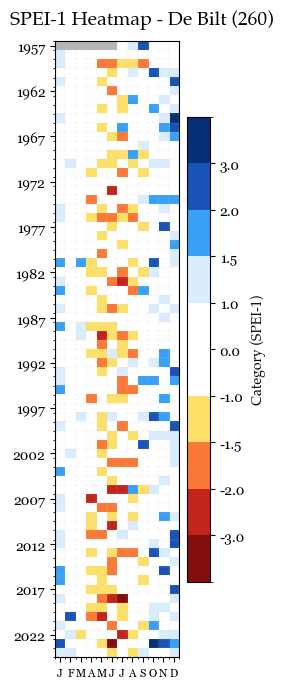

In [86]:
# Generate the heatmap plot
ax = generate_spei_heatmap_plot(new_stn, 1)

# Show the plot
plt.show()

##### SPEI-3

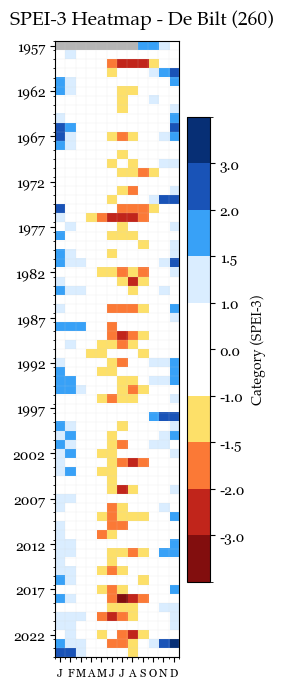

In [87]:
# Generate the heatmap plot
ax = generate_spei_heatmap_plot(new_stn, 3)

# Show the plot
plt.show()

##### SPEI-6

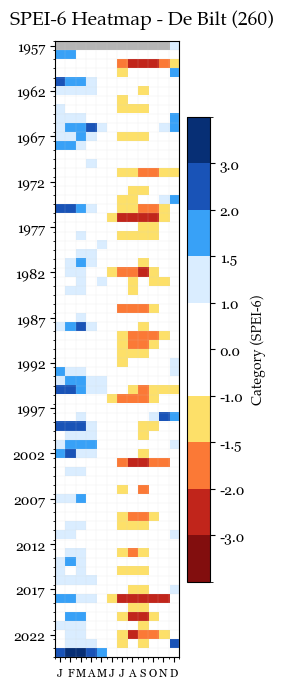

In [88]:
# Generate the heatmap plot
ax = generate_spei_heatmap_plot(new_stn, 6)

# Show the plot
plt.show()

##### SPEI-9

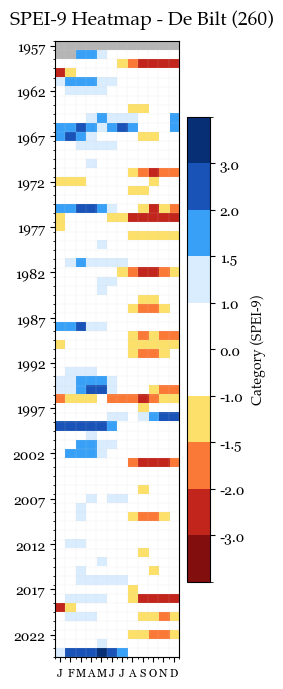

In [89]:
# Generate the heatmap plot
ax = generate_spei_heatmap_plot(new_stn, 9)

# Show the plot
plt.show()

##### SPEI-12

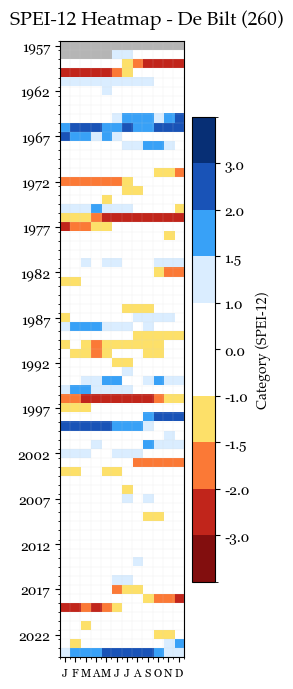

In [90]:
# Generate the heatmap plot
ax = generate_spei_heatmap_plot(new_stn, 12)

# Show the plot
plt.show()

##### SPEI-24

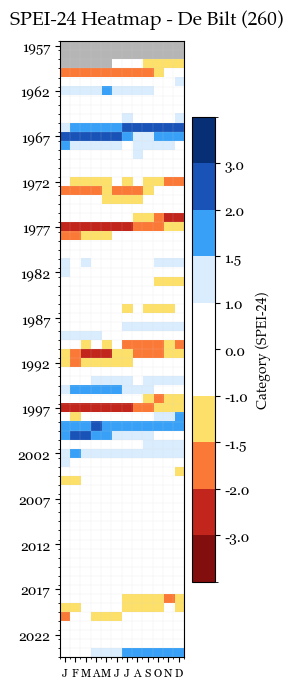

In [91]:
# Generate the heatmap plot
ax = generate_spei_heatmap_plot(new_stn, 24)

# Show the plot
plt.show()

### Conclusion


The main underlying question for the analysis in this section is the following: <em>Have Dutch extreme droughts and/or wetness become more frequent and intense recently?</em>

From a short-term perspective, extreme drought and/or wetness seem to indeed be more frequent and more intense in recent years. This can be inferred from the heatmap plots for SPEI-1, -3 and -6 above.

Surprisingly, these more intense short-term patterns are not reflected in the longer-term SPEI figures (-9, -12 and -24). This seems to indicate that the seasonal patterns (within a single year) are intensifying and diverging. While, in contrast, the long-term (multi-year) trend seems to be stable - at least for now.

The latter would mean good news for the parts of the water system that respond slowly to meteorological changes. Think of deeper groundwater layers, large-scale water resources and aquifer recharge patterns.

In terms of policy, this could imply that drought mitigation measures should address the shallower, fast-responding components of the water system in the first place. As part of these mitigation measures, even the more slowly-reacting, deeper parts within the water system (e.g.: investments in long-term water storage) can be of help, since their long-term SP(E)I driver is (at least for now) behaving in a stable way.

## Post-section 1: Important considerations for interpreting SP(E)I data

In this section the most important considerations for interpreting, comparing and analyzing SP(E)I data are addressed.

### Type(s) of distribution to fit to the precipitation sums

In literature the Gamma distribution is the default distribution to fit precipitation sums to (for SPI). In the work of [Vicente-Serrano et al. (2010)](https://doi.org/10.1175/2009JCLI2909.1) a log-normal distribution is used for SPEI.

This notebook demonstrated a different approach that is more in line with the study of [Guenang & Kamga, 2014](https://doi.org/10.1175/JAMC-D-14-0032.1): fitting the distribution type that gives the best approximation of the actual data (Gamma, exponential, log-normal or Weibull).

From the Dutch precipitation pattern results obtained here, the differences in fit quality between Gamma, log-normal and Weibull are relatively small, while exponential tends to not work well.

There is something to say for either choosing a fixed distribution type or a best-fit distribution type, depending on the scope of research. 

### Fit entire history of data or a reference period

In this notebook we have made best-fit distributions using the entire history of data available to us, since the goal was to find generic patterns and trends.

However, if the emphasis of a study is to detect drift and/or offsets compared to a fixed period in time (say, 1951-1980), one could also choose to fit a distribution to only that reference period.

The same generic trends and patterns should show up in both cases, although the scales of magnitude of events will possibly differ. 

In short, taking a reference period sounds like a sensible choice if the aim of a study is to map change.

### Seasonal corrections: to do or not to do


Note that in this notebook and the underlying code, all-season SP(E)I scores were calculated. In some more seasonal-focused studies, the SP(E)I scores may sometimes be corrected for the time of the year.

This means that, for instance, the SP(E)I-3 scores for April would instead be based on a best-fit distribution for only the February, March and April history of data. In contrast, all historic 3-month periods are lumped together in the same distribution to calculate the SP(E)I scores in this notebook. 

Either of these approaches could be deemed valid depending on the scope of study: seasonal versus generic.

### Recommendations

The following should be clarified in all cases when interpreting, comparing and analyzing SP(E)I scores:
- The <b>distribution type</b> that was fitted to the (net) precipitation data before calculating the SP(E)I scores
    - Examples: Gamma, exponential, Log-normal, Weibull, or other
- The <b>timeframe period</b> of (net) precipitation data that was used to fit to a distribution
    - Examples: the full available history, or a reference period of e.g. 30 or 60 years
- Whether <b>seasonal corrections</b> were applied during the fitting of a distribution to the (net) precipitation data
    - Examples: use entire 3-month history for SPI-3 in April, or only the (net) precipitation history of Feb, Mar, Apr

### Similar Python package for SP(E)I
A Python package for transforming (net) precipitation timeseries to SP(E)I scores [can be found on GitHub through this link (e/baumer/standard_precip)](https://github.com/e-baumer/standard_precip). 

Disclaimer: I am not affiliated with the author(s) of the package. 

## Post-section 2: Reflection

### Final words

First of all - congratulations for reaching this far down this last Notebook in the KNMI weather series - it was a long read!

Nevertheless I hope that you have found its content useful, insightful and inspirational.

We have succesfully analyzed and quantified periods of drought and wetness by using <em>Standardized Indexes</em> named <b>SPI</b> and <b>SPEI</b>. We have also filled missing values from precipitation datasets using the advanced <em><b>MICE</b> (Multivariate or Multiple Imputation by Chained Equations)</em> imputation algorithm.

The work in this notebook attempts to combine specialistic meteorological and hydrological domain knowledge with more generically-oriented Data Science approaches. New valuable insights are produced by combining best practices from both topics.

The SP(E)I specialty workflow shown here has increased my understanding and confidence when it comes to utilizing meteorological datasets. Hopefully the same applies to you as a reader!

### Broader picture

One of my main motivations for diving into the SP(E)I scores in detail is because the insights gained can be used quite universally, even beyond the scopes of meteorology, hydrology and climate studies.

First of all, SP(E)I scores are <em>standardized</em> and <em>continuous</em>. This means that they serve as excellent potential input feature for any Machine Learning or Deep Learning model that tries to link certain weather phenomena to certain research or business problems.

Within the realm of Data Science, Machine Learning and predictive modeling, meteo-based standardized scores could be used as input features for (partially) explaining many other events. Some random examples of such are:
- Predicting season-by-season ice cream consumption and its effect on e.g. stock prices of food companies
- Forecasting the expected claims that emergency insurance funds will need to pay out, and whether premiums need to rise to reflect (increasing) risk and uncertainty
- Describing seasonal fluctuations in real estate prices
- Assessing the seasonal demand for e.g. urban parking spots (usually the wetter, the higher the demand)
- Drought monitoring / early warning systems: send out e.g. notifications and reports on additional data once certain drought or wetness thresholds are exceeded

### Best practice suggestion for production enviroments

When linking all parts of the analysis together as in this Notebook, the chain of steps in the workflow tends to become relatively long fast. 

The main reason for this is the large number of small data modifications that are needed to glue the analysis components to one bigger workflow. Generally speaking, as the number of steps in a workflow increase, so does it complexity, thereby potentially negatively affecting its stability.

For production environments I would recommend to split up the data retrieval, transformation and aggregation steps in separate data pipeline flows, e.g. using Medallion Architecture principles.

## Closing notes

Amazing job on reaching the end of this Notebook!

This concludes the series covering KNMI weather examples within my Data Science Portfolio repository. 

I have been more than happy to bring you along on this meteorological journey full of data-driven workflows, visualizations and insights. Hope you have enjoyed reading through it and have found it useful, insightful and inspirational.

Very happy to possibly seeing you back later on! As always, also feel free to check out any another part of this GitHub repo.